In [1]:
import re
import time
import glob
import pywt

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### Concatenate all the files

In [2]:
# get path to all files
path = 'data/spectra/simulated_data/'
files = sorted(glob.glob(path + 'model_parameters_data*.txt'), key=lambda x: int(re.search(r'\d+', x).group()))
# write_data = open('model_parameters_data_all.txt', 'w')
# write_params  = open('model_parameters_all.txt', 'w')

# # start timer
# start_timer = time.time()
# # read in all files
# for file in files:
#     with open(file, 'r') as f:
#         # skip the first 10 lines in each file
#         for i in range(10):
#             f.readline()
#             # read in the data from each file
#         data = f.readlines()
#         # get the length of the data in each file
#         length = len(data)
#         # write the data to the output file in the same order as the files
#         for i in range(length):
#             write_data.write(data[i])
            
# # close the files
# write_data.close()
# # # check how much time it took
# print(time.time() - start_timer)      

In [3]:
# start_timer = time.time()
# # get the params data
# df_param = pd.DataFrame()
# for file in files:
#     # get the parameters used
#     df_param = df_param.append(pd.read_csv(file, skiprows=1, nrows=6, header=None, sep=' ', names=['A', 'B', 'C', 'D']))
#     # save the dataframe to a csv file
#     df_param.to_csv('model_parameters_data.csv', index=False)
    
# print(time.time() - start_timer)

#### Load the files 

In [4]:
start_time = time.time()
df_data = pd.read_csv('data/params/model_parameters_data_all.txt', sep=' ', header=None) # all data dataframe
print(time.time() - start_time)
df_data.head()

63.51965284347534


,0,1
0,238.85800,5.856426e-15
1,238.85801,5.856426e-15
2,238.85802,5.856426e-15
3,238.85803,5.856426e-15
4,238.85804,5.856426e-15


In [5]:
df_data.shape

(178500000, 2)

In [6]:
df_param = pd.read_csv('data/params/model_parameters_data.csv')
df_param.head()

,A,B,C,D
0,tcmb,=,2.730000e+00,K
1,ntot,=,5.346153e+16,cm-2
2,tex,=,5.575312e+01,K
3,fwhm,=,8.553742e+00,km/s
4,vlsr,=,9.844495e+01,km/s


In [7]:
# drop the second and fourth column
df_param.drop(['B', 'D'], axis=1, inplace=True)

In [8]:
# transform the data to the right dataframe
df_param = df_param.assign(g = df_param.groupby('A').cumcount()).pivot(index='g', columns='A', values='C')

In [9]:
df_param.head(10)

A,fwhm,ntot,size,tcmb,tex,vlsr
g,,,,,,
0,8.553742,5.346153e+16,0.890984,2.73,55.753122,98.444948
1,4.784038,7.673772e+16,1.354163,2.73,346.077502,56.622720
2,3.949914,1.561409e+17,0.886680,2.73,183.545036,-94.691227
3,2.142821,3.716288e+17,1.655878,2.73,279.396765,-126.118547
4,2.284713,1.906584e+16,1.370366,2.73,57.472048,-100.527838
5,8.933520,3.006530e+16,1.878052,2.73,280.178081,-118.899395
6,8.591939,1.275973e+17,0.638275,2.73,341.143697,-17.193075
7,1.415495,1.940967e+17,2.451344,2.73,284.644217,-104.418332
8,5.424837,2.581844e+17,0.256391,2.73,190.208317,58.261635


In [10]:
df_param.columns

Index(['fwhm', 'ntot', 'size', 'tcmb', 'tex', 'vlsr'], dtype='object', name='A')

In [11]:
columns = ['Frequency', 'Intensity']
df_data.columns = columns
df_data.shape

(178500000, 2)

In [12]:
df_data.head()

,Frequency,Intensity
0,238.85800,5.856426e-15
1,238.85801,5.856426e-15
2,238.85802,5.856426e-15
3,238.85803,5.856426e-15
4,238.85804,5.856426e-15


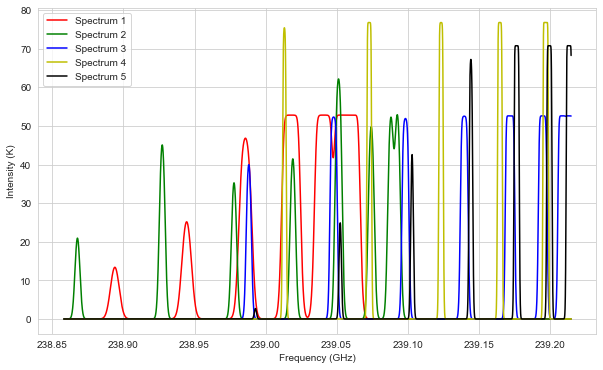

In [13]:
freq_sig = np.array(np.array_split(df_data['Frequency'], len(files)))
signal = np.array(np.array_split(df_data['Intensity'], len(files)))

# plot the signal in one plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plt.plot(freq_sig[0],  signal[0], color='r', label='Spectrum 1')
plt.plot(freq_sig[1], signal[1], color='g', label='Spectrum 2')
plt.plot(freq_sig[2], signal[2], color='b', label='Spectrum 3')
plt.plot(freq_sig[3], signal[3], color='y', label='Spectrum 4')
plt.plot(freq_sig[4], signal[4], color='k', label='Spectrum 5')
plt.xlabel("Frequency (GHz)")
plt.ylabel("Intensity (K)")
plt.legend()
plt.show()

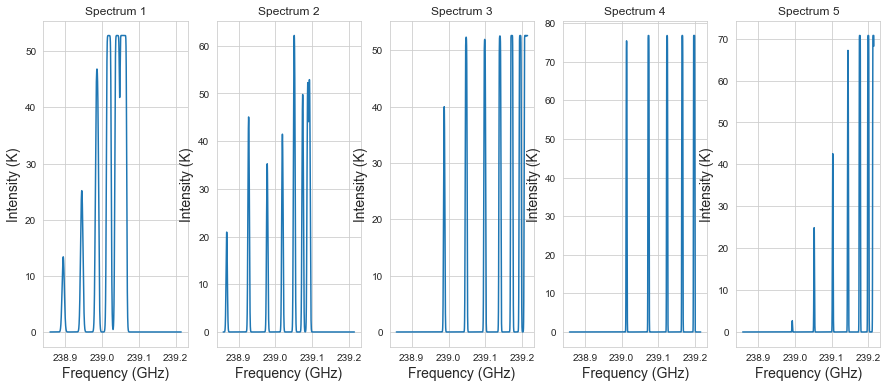

In [14]:
# plot the data in separate plots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 6))
sns.set_style("whitegrid")
for i, ax in enumerate(axes.ravel(), start=1):
    ax.plot(freq_sig[i-1], signal[i-1], label='Spectrum {}'.format(i))
    ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
    ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
    ax.set_title("Spectrum {}".format(i))
    
# plt.savefig('../spectra/simulated_data/spectrum_plots.png')

In [15]:
# print(pywt.wavelist())

### Feature Extraction - Wavelet Decomposition

In [16]:
#create a  feature vector array for each spectrum 
feature_vector = np.zeros((len(signal), int(df_data.shape[0]/len(files))))
detail_coeffs = np.zeros((len(signal), 558))
approx_coeffs = np.zeros((len(signal), 558))
level = 6
wname = 'db35'
def decompose_signal_dwt(_signal, wavelet=wname, mode='per', level=level):
    """
    Performs wavelet denoising on the given signal.
    """
    # loop throuh all the spectra 
    for spectra_index in range(len(_signal)):
        # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
        coeffs = pywt.wavedec(_signal[spectra_index], wavelet=wavelet, mode=mode, level=level)
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
        detail_coeffs[spectra_index, :] = coeff_arr[coeff_slices[1]['d']] # 4th level detail coeffs 
        # get the approximation coeffs
        approx_coeffs[spectra_index, :] = coeffs[0] # 4th level approximation coeffs
        
        reconstructed_signal = pywt.waverec(coeffs, wavelet=wavelet, mode=mode)
        feature_vector[spectra_index, :] = coeff_arr[:int(df_data.shape[0]/len(files))]
        # add the coeff_arr to the dataframe for each spectra
        # df_data['fv_dwt_{}'.format(wavelet)] = pd.Series(feature_vector.reshape(1, -1)[0], index=df_data.index) #TODO: find a way to optimize (or comment it out)
        
    return coeff_arr, coeff_slices

In [17]:
feature_vector.shape

(5000, 35700)

In [18]:
start_timer = time.time()
coeff_arr, coeff_slices = decompose_signal_dwt(signal)
print(time.time() - start_timer)
df_data

28.02085280418396


,Frequency,Intensity
0,238.85800,5.856426e-15
1,238.85801,5.856426e-15
2,238.85802,5.856426e-15
3,238.85803,5.856426e-15
4,238.85804,5.856426e-15
...,...,...
178499995,239.21495,2.055038e+01
178499996,239.21496,2.055117e+01
178499997,239.21497,2.055195e+01
178499998,239.21498,2.055271e+01


In [19]:
detail_coeffs.shape
detail_coeffs

array([[ 1.44567086e-15, -1.48374604e-15,  9.83085519e-16, ...,
        -1.81782499e-15, -2.08740455e-15,  4.99583235e-16],
       [-4.11916043e-07,  1.20322052e-07,  6.80050426e-08, ...,
        -1.44688231e-07,  2.98156030e-07,  4.45645072e-07],
       [ 2.34974696e+01,  1.27239275e+01, -2.85064535e+01, ...,
         2.82022230e+01, -8.00256423e+00, -5.28035841e+01],
       ...,
       [ 7.05193751e-07,  1.62311298e-06, -8.37051520e-07, ...,
        -5.33340507e-05,  3.65484294e-05, -1.26538291e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.27368074e+00,  4.90065478e+00, -1.10879759e+01, ...,
         1.10262101e+01, -3.08527822e+00, -2.07222200e+01]])

## Wavelet Decomposition Plots

In [20]:
def decomposed_dwt_detail_coeffs_plots(_signal, wavelet=wname, level=level):
    """
    Plots of the detail coeffs of the signal.
    """
    # plot the reconstructed signal and the original signal in one plot
    for spectra_index in range(len(_signal)):                     
        # compute the maximum useful level of decomposition for each wavelet                        
        # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
        fig, axes = plt.subplots(nrows=1, ncols=level, dpi=400, sharey='none', sharex='all', figsize=(18, 5))
        sns.set_style("whitegrid")
        for i, ax in enumerate(axes.ravel(), start=1):
            ax.plot(coeff_arr[coeff_slices[i]['d']], label='Level {}'.format(i))
            ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
            ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
            ax.set_title("Spectrum {} detail coeffiecients at level {} for {} ".format(spectra_index+1, i, wavelet)) 
            
        plt.show()

In [21]:
# decomposed_dwt_detail_coeffs_plots(signal) 

In [22]:
# TODO: find a way to plot the detail coefficients of the signal
def decomposed_dwt_approx_coeffs_plots(_signal, wavelet=wname, level=level):
    
    for spectra_index in range(len(_signal)):
        fig, axes = plt.subplots(nrows=1, ncols=level, figsize=(10, 6))
        sns.set_style("whitegrid")
        for i, ax in enumerate(axes.ravel(), start=1):
            ax.plot(coeff_arr[coeff_slices[1]['d']])
            ax.set_title("Spectrum {} approximation coeffiecients at level {} for {} ".format(spectra_index+1, i,  wavelet))
            
        plt.show()

In [23]:
# decomposed_dwt_approx_coeffs_plots(signal)

### Get Features and Labels

In [24]:
# fv = np.zeros((len(signal), int(df.shape[0]/len(files))))
# for spectra_index in range(len(signal)):
#     # get the level 3 detail coefficients
#     detail_coeffs = coeff_arr[coeff_slices[3]['d']]

# fv  = detail_coeffs
# labels =dff

In [25]:
# len(signal)

approx_coeffs.shape

(5000, 558)

 #### Have a glimpse look at any of the signal and its generated detail and approximation coefficients 

In [26]:

# for spectra_index in range(len(signal)):                     
#         # compute the maximum useful level of decomposition for each wavelet                        
#         # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
#         fig, axes = plt.subplots(nrows=1, ncols=10, sharey='none', sharex='all', figsize=(20, 7))
#         sns.set_style("whitegrid")
#         for i, ax in enumerate(axes.ravel(), start=1):
#             ax.plot(signal[spectra_index], label='Spectrum {}'.format(spectra_index))
#             # ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
#             # ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
#             # ax.set_title("Spectrum {} detail coeffiecients at level {} for {} ".format(spectra_index+1, i, wavelet)) 

#     # ax[0,1].plot(signal[spectra_index], label='original')
#     # ax[1,1].plot(approx_coeffs[spectra_index], label='spectrum {} approx coeff'.format(spectra_index+1))
#     # ax[2,1].plot(detail_coeffs[spectra_index], label='spectrum {} detail coeff'.format(spectra_index+1))
# plt.legend()
# plt.show()

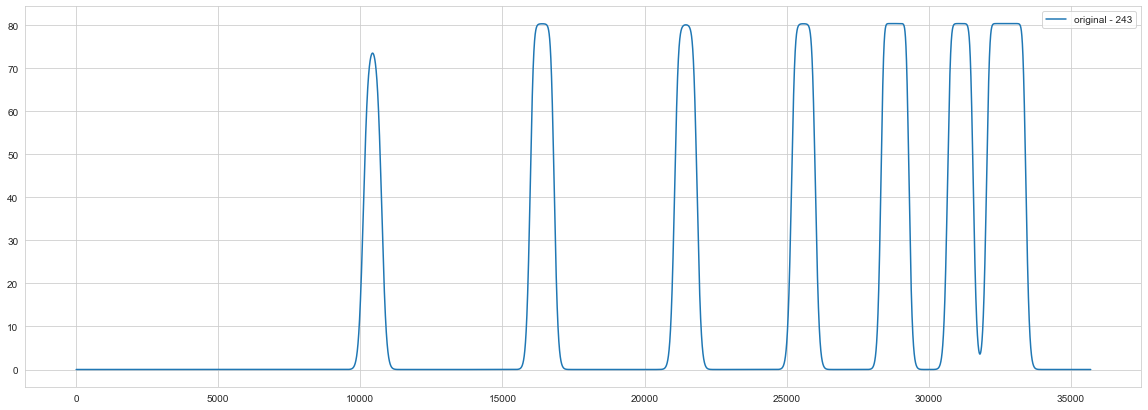

In [27]:
plt.figure(figsize=(20,7))
plt.plot(signal[243], label='original - 243')
plt.legend()
# plt.savefig("data/5K_gen_files/original.png")
plt.show()

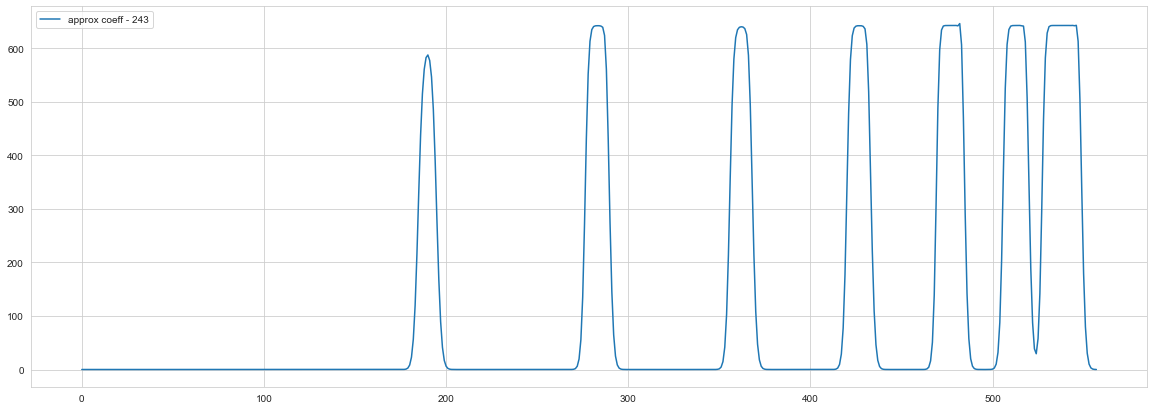

In [28]:
plt.figure(figsize=(20,7))
plt.plot(approx_coeffs[243], label='approx coeff - 243')
plt.legend()
# plt.savefig("data/5K_gen_files/approx_level6.png")
plt.show()

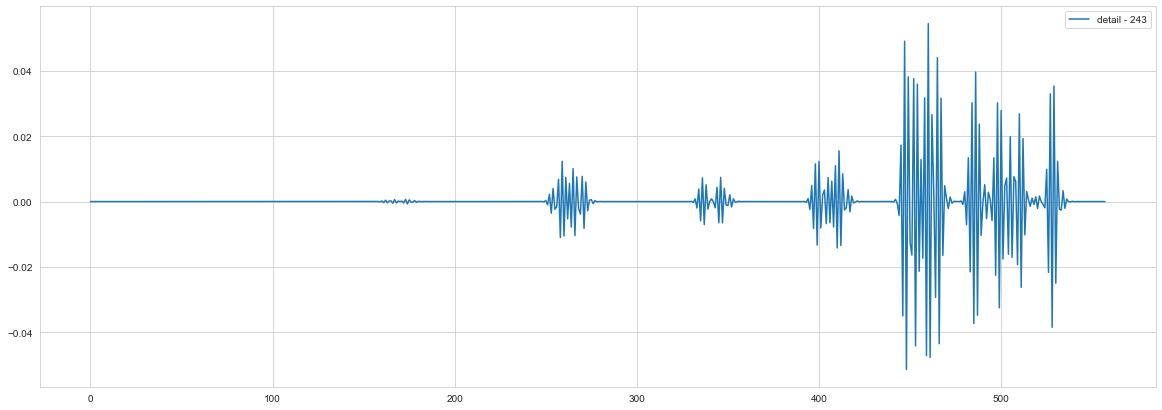

In [29]:
plt.figure(figsize=(20,7))
plt.plot(detail_coeffs[243], label='detail - 243')
plt.legend()
# plt.savefig("data/5K_gen_files/detail_level6.png")
plt.show()

In [30]:
features = detail_coeffs
labels_ = df_param

print('feature_shape: ', features.shape, 'labels_shape: ', labels_.shape)


feature_shape:  (5000, 558) labels_shape:  (5000, 6)


In [31]:
# drop the tcmb column
labels_.drop(columns=['tcmb'], inplace=True)

#### save the true params to a file

In [32]:
labels_.head()

A,fwhm,ntot,size,tex,vlsr
g,,,,,
0,8.553742,5.346153e+16,0.890984,55.753122,98.444948
1,4.784038,7.673772e+16,1.354163,346.077502,56.622720
2,3.949914,1.561409e+17,0.886680,183.545036,-94.691227
3,2.142821,3.716288e+17,1.655878,279.396765,-126.118547
4,2.284713,1.906584e+16,1.370366,57.472048,-100.527838


In [33]:
# get the last 1500 data of the parameters from labels 
df_param = df_param.iloc[-1500:, :]
# save the vals to a csv file
df_param.to_csv("data/5K_gen_files/true_param_vals.csv")
df_param.head()


A,fwhm,ntot,size,tex,vlsr
g,,,,,
3500,7.828761,2.925206e+17,1.289278,134.365845,-33.557593
3501,9.788820,1.276940e+16,2.184382,291.871977,17.069059
3502,4.531839,4.322910e+16,0.454676,48.179125,19.677568
3503,7.596641,1.803645e+17,1.058388,80.813481,-34.419252
3504,7.777998,4.824737e+16,0.218195,333.687364,-41.638212


In [34]:
labels_

A,fwhm,ntot,size,tex,vlsr
g,,,,,
0,8.553742,5.346153e+16,0.890984,55.753122,98.444948
1,4.784038,7.673772e+16,1.354163,346.077502,56.622720
2,3.949914,1.561409e+17,0.886680,183.545036,-94.691227
3,2.142821,3.716288e+17,1.655878,279.396765,-126.118547
4,2.284713,1.906584e+16,1.370366,57.472048,-100.527838
...,...,...,...,...,...
4995,7.543883,3.457261e+17,0.543501,97.454592,113.945758
4996,8.223381,2.265878e+17,2.126648,393.754790,-100.649905
4997,5.504152,4.031104e+17,0.274057,348.425202,-78.767408


In [35]:
df = pd.DataFrame(approx_coeffs)
# df = pd.concat([approx_coeffs, labels_], axis=1)

In [36]:
df

,0,1,2,3,4,5,6,7,8,9,...,548,549,550,551,552,553,554,555,556,557
0,1.252696e-23,-1.397523e-23,-7.887989e-23,5.352915e-22,-1.712768e-21,2.065467e-21,1.127461e-20,-8.903603e-20,3.650282e-19,-1.078731e-18,...,-5.773273e-30,3.579354e-29,7.029195e-29,-1.550782e-27,5.629879e-27,5.872970e-27,-1.167958e-25,3.906688e-25,-1.671307e-25,-3.205910e-24
1,5.473250e-16,-1.709609e-16,8.669659e-16,3.715313e-14,-4.816982e-13,2.987106e-12,-1.214815e-11,3.486671e-11,-6.670663e-11,4.477255e-11,...,-1.121177e-21,-1.804967e-21,4.859350e-20,-1.547910e-19,-4.889658e-19,4.951100e-18,-1.174242e-17,-2.081227e-17,2.056546e-16,-5.464414e-16
2,2.578577e+02,1.168463e+02,3.768305e+01,9.320104e+00,1.547071e+00,5.870485e-01,-4.411530e-01,7.553046e-01,-9.641696e-01,4.079872e+00,...,1.465871e+02,3.014446e+02,3.903789e+02,4.162626e+02,4.204798e+02,4.204716e+02,4.217841e+02,4.177177e+02,4.302328e+02,3.922715e+02
3,7.003132e+02,5.189017e+02,1.860583e+02,3.343418e+01,3.157934e+00,1.635765e-01,4.849733e-03,8.503970e-05,8.885985e-07,5.453373e-09,...,1.125538e+01,-1.199322e+01,7.529031e+00,1.293458e+01,-7.646080e+01,2.013076e+02,4.949206e+02,6.030864e+02,6.206548e+02,5.806760e+02
4,4.011934e+02,5.473459e+02,5.614061e+02,5.511863e+02,6.300411e+02,4.499567e+02,1.657073e+02,3.228951e+01,3.952007e+00,-4.927199e-01,...,-4.348844e-02,-2.176837e-01,5.221363e-01,-6.623372e-01,1.832596e-01,1.902249e+00,-7.887000e+00,2.324529e+01,-5.904318e+01,1.199046e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.006378e-24,-4.936329e-25,-1.656231e-23,8.198744e-23,-2.594823e-22,4.611113e-22,1.110327e-21,-1.449146e-20,7.467835e-20,-2.648116e-19,...,-2.254772e-31,1.873187e-30,6.543793e-30,-1.253618e-28,3.848217e-28,1.629134e-27,-1.562587e-26,3.770956e-26,7.383226e-26,-7.430665e-25
4996,5.216800e+02,5.479072e+02,5.621166e+02,5.659160e+02,5.597666e+02,5.427660e+02,5.129742e+02,4.684485e+02,4.090956e+02,3.385170e+02,...,1.563145e+01,2.989952e+01,5.377674e+01,9.059632e+01,1.423834e+02,2.081174e+02,2.827614e+02,3.582587e+02,4.263590e+02,4.814639e+02
4997,8.097230e+01,8.097326e+01,8.103143e+01,8.109333e+01,8.111175e+01,8.108867e+01,8.091216e+01,8.026807e+01,7.713124e+01,6.709982e+01,...,2.066721e+01,3.919776e+01,5.841564e+01,7.167219e+01,7.800851e+01,8.025293e+01,8.090011e+01,8.106477e+01,8.108811e+01,8.103908e+01
4998,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [37]:
# convert the ntot column to log values 
labels_['ntot'] = np.log(labels_['ntot'])

In [38]:
labels_

A,fwhm,ntot,size,tex,vlsr
g,,,,,
0,8.553742,38.517739,0.890984,55.753122,98.444948
1,4.784038,38.879170,1.354163,346.077502,56.622720
2,3.949914,39.589535,0.886680,183.545036,-94.691227
3,2.142821,40.456672,1.655878,279.396765,-126.118547
4,2.284713,37.486675,1.370366,57.472048,-100.527838
...,...,...,...,...,...
4995,7.543883,40.384423,0.543501,97.454592,113.945758
4996,8.223381,39.961909,2.126648,393.754790,-100.649905
4997,5.504152,40.537987,0.274057,348.425202,-78.767408


In [39]:
df = pd.concat([df, labels_], axis=1)

In [40]:
# drop the values less than -60 in the vlsr column
df = df.drop(df[df['vlsr'] < -60].index)

In [41]:
df

,0,1,2,3,4,5,6,7,8,9,...,553,554,555,556,557,fwhm,ntot,size,tex,vlsr
0,1.252696e-23,-1.397523e-23,-7.887989e-23,5.352915e-22,-1.712768e-21,2.065467e-21,1.127461e-20,-8.903603e-20,3.650282e-19,-1.078731e-18,...,5.872970e-27,-1.167958e-25,3.906688e-25,-1.671307e-25,-3.205910e-24,8.553742,38.517739,0.890984,55.753122,98.444948
1,5.473250e-16,-1.709609e-16,8.669659e-16,3.715313e-14,-4.816982e-13,2.987106e-12,-1.214815e-11,3.486671e-11,-6.670663e-11,4.477255e-11,...,4.951100e-18,-1.174242e-17,-2.081227e-17,2.056546e-16,-5.464414e-16,4.784038,38.879170,1.354163,346.077502,56.622720
6,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.591939,39.387656,0.638275,341.143697,-17.193075
8,7.090502e-13,-4.187573e-14,-4.116996e-12,6.750280e-11,-5.849066e-10,3.129112e-09,-1.148057e-08,2.906215e-08,-4.129796e-08,-3.645064e-08,...,4.785012e-15,-1.282609e-14,-1.445702e-14,1.951000e-13,-5.740078e-13,5.424837,40.092450,0.256391,190.208317,58.261635
9,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.741134,38.956817,2.189909,23.272285,97.018706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4991,-6.396089e-71,5.435098e-66,-3.787173e-62,-1.413598e-58,1.350365e-55,3.380691e-53,-9.470847e-51,-1.538983e-48,2.254426e-46,3.421736e-45,...,0.000000e+00,0.000000e+00,4.766513e-98,2.798401e-85,-5.874858e-78,4.244915,39.908756,0.515850,165.566896,28.059296
4992,5.432666e-15,2.938794e-15,-7.914479e-14,5.299678e-13,-2.551573e-12,8.605269e-12,-1.638006e-11,-1.344301e-11,2.504766e-10,-1.167559e-09,...,1.834733e-17,-7.644527e-17,4.991831e-17,6.740933e-16,-2.971060e-15,5.782424,39.521472,0.647373,64.906153,82.064251
4994,0.000000e+00,3.594988e-105,1.761138e-88,-1.077844e-79,6.951713e-73,5.071065e-69,-1.116122e-63,1.914844e-59,-1.219860e-56,-9.963630e-54,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.586782,38.070933,0.418121,216.480143,94.771772
4995,2.006378e-24,-4.936329e-25,-1.656231e-23,8.198744e-23,-2.594823e-22,4.611113e-22,1.110327e-21,-1.449146e-20,7.467835e-20,-2.648116e-19,...,1.629134e-27,-1.562587e-26,3.770956e-26,7.383226e-26,-7.430665e-25,7.543883,40.384423,0.543501,97.454592,113.945758


In [42]:
X  = df.iloc[:, :558]
y = df.iloc[:, -5:]


In [43]:
X 

,0,1,2,3,4,5,6,7,8,9,...,548,549,550,551,552,553,554,555,556,557
0,1.252696e-23,-1.397523e-23,-7.887989e-23,5.352915e-22,-1.712768e-21,2.065467e-21,1.127461e-20,-8.903603e-20,3.650282e-19,-1.078731e-18,...,-5.773273e-30,3.579354e-29,7.029195e-29,-1.550782e-27,5.629879e-27,5.872970e-27,-1.167958e-25,3.906688e-25,-1.671307e-25,-3.205910e-24
1,5.473250e-16,-1.709609e-16,8.669659e-16,3.715313e-14,-4.816982e-13,2.987106e-12,-1.214815e-11,3.486671e-11,-6.670663e-11,4.477255e-11,...,-1.121177e-21,-1.804967e-21,4.859350e-20,-1.547910e-19,-4.889658e-19,4.951100e-18,-1.174242e-17,-2.081227e-17,2.056546e-16,-5.464414e-16
6,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
8,7.090502e-13,-4.187573e-14,-4.116996e-12,6.750280e-11,-5.849066e-10,3.129112e-09,-1.148057e-08,2.906215e-08,-4.129796e-08,-3.645064e-08,...,-1.141271e-18,-1.073160e-18,4.654126e-17,-1.687705e-16,-3.809738e-16,4.785012e-15,-1.282609e-14,-1.445702e-14,1.951000e-13,-5.740078e-13
9,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4991,-6.396089e-71,5.435098e-66,-3.787173e-62,-1.413598e-58,1.350365e-55,3.380691e-53,-9.470847e-51,-1.538983e-48,2.254426e-46,3.421736e-45,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.766513e-98,2.798401e-85,-5.874858e-78
4992,5.432666e-15,2.938794e-15,-7.914479e-14,5.299678e-13,-2.551573e-12,8.605269e-12,-1.638006e-11,-1.344301e-11,2.504766e-10,-1.167559e-09,...,-5.439281e-21,7.486248e-21,1.727202e-19,-9.958580e-19,2.032977e-19,1.834733e-17,-7.644527e-17,4.991831e-17,6.740933e-16,-2.971060e-15
4994,0.000000e+00,3.594988e-105,1.761138e-88,-1.077844e-79,6.951713e-73,5.071065e-69,-1.116122e-63,1.914844e-59,-1.219860e-56,-9.963630e-54,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4995,2.006378e-24,-4.936329e-25,-1.656231e-23,8.198744e-23,-2.594823e-22,4.611113e-22,1.110327e-21,-1.449146e-20,7.467835e-20,-2.648116e-19,...,-2.254772e-31,1.873187e-30,6.543793e-30,-1.253618e-28,3.848217e-28,1.629134e-27,-1.562587e-26,3.770956e-26,7.383226e-26,-7.430665e-25


In [44]:
y

,fwhm,ntot,size,tex,vlsr
0,8.553742,38.517739,0.890984,55.753122,98.444948
1,4.784038,38.879170,1.354163,346.077502,56.622720
6,8.591939,39.387656,0.638275,341.143697,-17.193075
8,5.424837,40.092450,0.256391,190.208317,58.261635
9,2.741134,38.956817,2.189909,23.272285,97.018706
...,...,...,...,...,...
4991,4.244915,39.908756,0.515850,165.566896,28.059296
4992,5.782424,39.521472,0.647373,64.906153,82.064251
4994,5.586782,38.070933,0.418121,216.480143,94.771772
4995,7.543883,40.384423,0.543501,97.454592,113.945758


In [45]:
y.shape

(3646, 5)

## Modelling

In [46]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [47]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Define a cross validation strategy

We use the cross_val_score function of Sklearn. However this function has not a shuffle attribute, we add then one line of code, in order to shuffle the dataset prior to cross-validation


The negative infront of the cross_val_score function is the scoring function, in this case the accuracy of the model. Thus it has to be minimised for the model to be good since we are using `neg_mean_squared_error` as the scoring function.

In [48]:
# validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train.values, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## Base models
1. LASSO Regression

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's **Robustscaler()** method on pipeline


In [49]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

2. ElasticNet Regression

Also known as **L1-L2 regularization**, this model is a combination of L1 and L2 regularization. It is a linear model that is trained using a regularized penalty term that is the sum of a L1 and L2 term. The ElasticNet model is more flexible in the choice of these two penalties and therefore more robust to outliers.

In [50]:
ENet = make_pipeline(
    RobustScaler(),
    ElasticNet(alpha=0.0005, 
    l1_ratio=.9, 
    random_state=3)
)

3. Kernel Ridge Regression

This model is a linear model with a kernel function. It is a linear model that is trained using a regularized penalty term that is the sum of a L1 and L2 term. The Kernel Ridge model is more flexible in the choice of these two penalties and therefore more robust to outliers.

In [51]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

4. Gradient Boosting Regression

Gradient Boosting is a non-linear model that is trained using a regularized penalty term that is the sum of a L1 and L2 term. It has a **huber** loss function that is robust to outliers.

In [52]:
GBoost = GradientBoostingRegressor(
    n_estimators=3000,
    learning_rate=0.05,
    max_depth=4,
    max_features='sqrt',
    min_samples_leaf=15,
    min_samples_split=10,
    loss='huber',
    random_state =5)
    

5. XGBoost Regression

In [53]:
model_xgb = xgb.XGBRegressor(
    colsample_bytree=0.4603, 
    gamma=0.0468,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=1.7817,
    n_estimators=2200,
    reg_alpha=0.4640,
    reg_lambda=0.8571,
    subsample=0.5213,
    silent=1,
    random_state =7,
    nthread = -1)

6. LightGBM Regression

In [54]:
model_lgb = lgb.LGBMRegressor(
    objective='regression',
    num_leaves=5,
    learning_rate=0.05,
    n_estimators=720,
    max_bin = 55,
    bagging_fraction = 0.8,
    bagging_freq = 5,
    feature_fraction = 0.2319,
    feature_fraction_seed=9,
    bagging_seed=9,
    min_data_in_leaf =6,
    min_sum_hessian_in_leaf = 11)

7. Random Forest Regression

In [63]:
rf = RandomForestRegressor(
    bootstrap='False',
    max_depth=90,
    max_features='log2',
    max_samples=0.8999999999999999,
    n_estimators=700,
    n_jobs=-1,
    verbose=2,
    random_state=5
)

## Base models scores

Lets see the scores of the base models when we use the **cross_val_score** function of Sklearn. This will accomplished using **MultiOutputRegressor** for each of the base models.

In [55]:
# use multioutput regression to get the rmse of the model
score = rmsle_cv(MultiOutputRegressor(lasso))
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 53.3164 (1.7890)



In [56]:
score = rmsle_cv(MultiOutputRegressor(ENet))
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 53.2455 (1.8558)



In [57]:
score = rmsle_cv(MultiOutputRegressor(KRR))
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 5229.4961 (347.9267)



In [58]:
score = rmsle_cv(MultiOutputRegressor(GBoost))
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 34.6791 (1.0297)



In [59]:
score = rmsle_cv(MultiOutputRegressor(model_xgb))
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[14:18:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:19:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:19:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  

In [60]:
score = rmsle_cv(MultiOutputRegressor(model_lgb))
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] 

In [64]:
score = rmsle_cv(MultiOutputRegressor(rf))
print("Random Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 4 of 700
building tree 5 of 700
building tree 3 of 700
building tree 2 of 700
building tree 1 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 21 of 700
building tree 19 of 700
building tree 20 of 700
building tree 22 of 700
building tree 27 of 700
building tree 29 of 700
building tree 25 of 700
building tree 23 of 700
building tree 28 of 700
building tree 24 of 700
building tree 30 of 700
building tree 26 of 700
building tree 31 of 700
building tree 33 of 700
building tree 34 of 700
building tree 32 of 700


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 37 of 700
building tree 35 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 38 of 700
building tree 47 of 700
building tree 36 of 700
building tree 42 of 700
building tree 46 of 700
building tree 40 of 700
building tree 44 of 700
building tree 48 of 700
building tree 49 of 700
building tree 57 of 700building tree 53 of 700

building tree 61 of 700
building tree 65 of 700
building tree 69 of 700
building tree 73 of 700
building tree 77 of 700
building tree 62 of 700
building tree 58 of 700
building tree 66 of 700
building tree 50 of 700
building tree 54 of 700
building tree 70 of 700
building tree 74 of 700
building tree 63 of 700
building tree 59 of 700
building tree 67 of 700
building tree 78 of 700
building tree 51 of 700
building tree 55 of 700
building tree 71 of 700
building tree 75 of 700
building tree 64 of 700
building tree 60 of 700
building tree 52 of 700
building tree 76 of 700
building tree 56

[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 4 of 700building tree 5 of 700

building tree 1 of 700
building tree 2 of 700building tree 3 of 700

building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 18 of 700
building tree 20 of 700
building tree 29 of 700
building tree 22 of 700
building tree 31 of 700
building tree 26 of 700
building tree 24 of 700
building tree 28 of 700
building tree 30 of 700
building tree 33 of 700
building tree 32 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 36 of 700
building tree 34 of 700
building tree 38 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 77 of 700
building tree 50 of 700
building tree 66 of 700
building tree 62 of 700
building tree 55 of 700
building tree 58 of 700
building tree 74 of 700
building tree 70 of 700
building tree 67 of 700
building tree 78 of 700
building tree 51 of 700
building tree 59 of 700
building tree 63 of 700
building tree 56 of 700
building tree 79 of 700
building tree 71 of 700
building tree 75 of 700building tree 68 of 700

building tree 52 of 700
building tree 60 of 700
building tree 64 of 700
building tree 80 of 700
building tree 72 of 700
building tree 81 of 700
building tree 76 of 700
building tree 85 of 700
building tree 89 of 700
building tree 93 of 700
building tree 97 of 700
building tree 82 of 700
building tree 101 of 700
building tree 86 of 700
building tree 105 of 700
building tree 90 of 700
building tree 94 of 700
building tree 109 of 700
building tree 83 of 700
building tree 102 of 700
building tree 98 of 700
building tree 87 of 700
building tree 91 of 700building tree

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 5 of 700building tree 7 of 700

building tree 2 of 700
building tree 3 of 700
building tree 8 of 700
building tree 6 of 700
building tree 4 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 18 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 20 of 700
building tree 22 of 700
building tree 24 of 700
building tree 31 of 700
building tree 26 of 700
building tree 33 of 700
building tree 28 of 700
building tree 35 of 700
building tree 30 of 700
building tree 37 of 700
building tree 32 of 700
building tree 39 of 700
building tree 34 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 38 of 700
building tree 36 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 50 of 700
building tree 53 of 700
building tree 51 of 700
building tree 54 of 700
building tree 52 of 700
building tree 55 of 700
building tree 57 of 700
building tree 61 of 700
building tree 73 of 700
building tree 65 of 700
building tree 69 of 700
building tree 77 of 700
building tree 62 of 700
building tree 58 of 700
building tree 70 of 700
building tree 74 of 700
building tree 78 of 700
building tree 66 of 700
building tree 56 of 700
building tree 71 of 700
building tree 63 of 700
building tree 79 of 700
building tree 59 of 700
building tree 75 of 700
building tree 67 of 700
building tree 64 of 700
building tree 60 of 700
building tree 72 of 700
building tree 76 of 700
building tree 80 of 700
building tree 68 of 700
building tree 81 of 700
building tree 85 of 700
building tree 89 of 700
building tree 82 of 700
building tree 93 of 700
building tree 86 of 700
building tree 97 of 700
building tree 101 of 700
building tree 105 of 700
building tree 83 of 700
building tree 

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 2 of 700building tree 4 of 700

building tree 5 of 700
building tree 1 of 700
building tree 3 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 18 of 700
building tree 27 of 700
building tree 20 of 700
building tree 29 of 700
building tree 22 of 700
building tree 24 of 700
building tree 26 of 700
building tree 31 of 700
building tree 28 of 700
building tree 30 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 32 of 700
building tree 39 of 700
building tree 41 of 700
building tree 34 of 700
building tree 36 of 700
building tree 38 of 700
building tree 40 of 700
building tree 42 of 700
b

[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


building tree 5 of 700
building tree 1 of 700building tree 2 of 700building tree 4 of 700building tree 3 of 700



building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 10 of 700
building tree 9 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 18 of 700
building tree 27 of 700
building tree 20 of 700
building tree 29 of 700
building tree 22 of 700
building tree 31 of 700
building tree 24 of 700
building tree 26 of 700
building tree 28 of 700
building tree 33 of 700
building tree 30 of 700
building tree 32 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 34 of 700
building tree 41 of 700
building tree 36 of 700
building tree 43 of 700
building tree 38 of 700
building tree 45 of 700
b

[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s


building tree 692 of 700
building tree 693 of 700
building tree 694 of 700
building tree 695 of 700
building tree 696 of 700
building tree 697 of 700
building tree 698 of 700
building tree 699 of 700
building tree 700 of 700


[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[

building tree 7 of 700
building tree 6 of 700building tree 5 of 700

building tree 1 of 700
building tree 8 of 700
building tree 4 of 700
building tree 3 of 700
building tree 2 of 700
building tree 9 of 700
building tree 10 of 700
building tree 13 of 700
building tree 11 of 700
building tree 12 of 700
building tree 15 of 700
building tree 16 of 700
building tree 14 of 700
building tree 17 of 700
building tree 18 of 700
building tree 29 of 700
building tree 23 of 700building tree 25 of 700

building tree 19 of 700
building tree 21 of 700
building tree 31 of 700
building tree 27 of 700
building tree 33 of 700
building tree 28 of 700
building tree 26 of 700
building tree 32 of 700
building tree 20 of 700
building tree 22 of 700
building tree 24 of 700
building tree 30 of 700
building tree 34 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 36 of 700
building tree 43 of 700
building tree 38 of 700
building tree 40 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 157 of 700
building tree 134 of 700
building tree 120 of 700
building tree 173 of 700
building tree 150 of 700
building tree 165 of 700
building tree 127 of 700
building tree 143 of 700
building tree 158 of 700
building tree 135 of 700
building tree 128 of 700
building tree 159 of 700
building tree 174 of 700
building tree 166 of 700
building tree 151 of 700
building tree 136 of 700
building tree 160 of 700
building tree 144 of 700
building tree 167 of 700
building tree 175 of 700
building tree 152 of 700
building tree 168 of 700
building tree 176 of 700
building tree 177 of 700
building tree 178 of 700
building tree 179 of 700
building tree 180 of 700
building tree 181 of 700
building tree 182 of 700
building tree 183 of 700
building tree 184 of 700
building tree 185 of 700
building tree 193 of 700
building tree 201 of 700
building tree 209 of 700
building tree 186 of 700
building tree 194 of 700
building tree 210 of 700
building tree 202 of 700
building tree 187 of 700


[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.2s finished


building tree 698 of 700
building tree 699 of 700
building tree 700 of 700


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 2 of 700
building tree 1 of 700
building tree 6 of 700
building tree 5 of 700
building tree 4 of 700building tree 3 of 700

building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 18 of 700building tree 29 of 700
building tree 31 of 700

building tree 20 of 700
building tree 22 of 700
building tree 24 of 700
building tree 26 of 700
building tree 28 of 700
building tree 30 of 700
building tree 32 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 34 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 36 of 700
building tree 38 of 700
b

[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 7 of 700
building tree 1 of 700
building tree 5 of 700
building tree 2 of 700building tree 4 of 700

building tree 6 of 700
building tree 3 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 18 of 700
building tree 29 of 700
building tree 20 of 700
building tree 31 of 700
building tree 22 of 700
building tree 24 of 700
building tree 26 of 700
building tree 33 of 700
building tree 30 of 700
building tree 28 of 700
building tree 32 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 34 of 700
building tree 36 of 700
building tree 38 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
b

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.3s


building tree 512 of 700
building tree 523 of 700
building tree 527 of 700
building tree 520 of 700
building tree 531 of 700
building tree 538 of 700
building tree 535 of 700
building tree 516 of 700
building tree 524 of 700
building tree 541 of 700
building tree 528 of 700
building tree 532 of 700
building tree 539 of 700
building tree 536 of 700
building tree 545 of 700
building tree 549 of 700
building tree 542 of 700
building tree 540 of 700
building tree 553 of 700
building tree 557 of 700
building tree 561 of 700
building tree 546 of 700
building tree 543 of 700
building tree 565 of 700
building tree 550 of 700
building tree 554 of 700
building tree 558 of 700
building tree 569 of 700
building tree 547 of 700
building tree 544 of 700
building tree 566 of 700
building tree 551 of 700
building tree 562 of 700
building tree 555 of 700
building tree 559 of 700
building tree 570 of 700
building tree 548 of 700
building tree 552 of 700
building tree 563 of 700
building tree 556 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700
building tree 1 of 700
building tree 4 of 700
building tree 3 of 700
building tree 5 of 700
building tree 7 of 700
building tree 6 of 700
building tree 10 of 700
building tree 11 of 700
building tree 8 of 700
building tree 9 of 700
building tree 12 of 700
building tree 15 of 700
building tree 13 of 700
building tree 14 of 700
building tree 21 of 700
building tree 17 of 700
building tree 18 of 700
building tree 22 of 700
building tree 16 of 700
building tree 19 of 700
building tree 23 of 700
building tree 20 of 700
building tree 24 of 700
building tree 29 of 700
building tree 25 of 700
building tree 26 of 700
building tree 30 of 700
building tree 27 of 700
building tree 31 of 700
building tree 35 of 700
building tree 33 of 700
building tree 36 of 700
building tree 34 of 700
building tree 28 of 700
building tree 32 of 700
building tree 39 of 700
building tree 37 of 700
building tree 40 of 700
building tree 38 of 700
building tree 43 of 700
building tree 41 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 75 of 700
building tree 72 of 700
building tree 79 of 700
building tree 76 of 700
building tree 81 of 700
building tree 80 of 700
building tree 82 of 700
building tree 85 of 700
building tree 83 of 700
building tree 86 of 700
building tree 84 of 700
building tree 93 of 700building tree 89 of 700building tree 97 of 700


building tree 87 of 700
building tree 90 of 700
building tree 98 of 700
building tree 94 of 700
building tree 88 of 700
building tree 91 of 700
building tree 99 of 700
building tree 95 of 700
building tree 105 of 700
building tree 101 of 700
building tree 109 of 700
building tree 92 of 700
building tree 100 of 700
building tree 96 of 700
building tree 106 of 700
building tree 102 of 700
building tree 110 of 700
building tree 113 of 700
building tree 121 of 700
building tree 107 of 700
building tree 103 of 700
building tree 122 of 700
building tree 114 of 700
building tree 111 of 700
building tree 108 of 700
building tree 104 of 700
building tree 115 of 700

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


building tree 3 of 700
building tree 5 of 700
building tree 6 of 700
building tree 4 of 700
building tree 2 of 700building tree 1 of 700

building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 18 of 700
building tree 20 of 700
building tree 27 of 700
building tree 22 of 700
building tree 24 of 700
building tree 26 of 700
building tree 29 of 700
building tree 28 of 700
building tree 31 of 700
building tree 33 of 700
building tree 30 of 700
building tree 32 of 700
building tree 35 of 700
building tree 37 of 700
building tree 34 of 700
building tree 39 of 700
building tree 41 of 700
building tree 36 of 700
building tree 43 of 700
building tree 38 of 700
building tree 40 of 700
b

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s


building tree 4 of 700building tree 6 of 700

building tree 1 of 700
building tree 7 of 700
building tree 3 of 700
building tree 2 of 700
building tree 5 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 18 of 700
building tree 20 of 700
building tree 29 of 700
building tree 22 of 700
building tree 31 of 700
building tree 24 of 700
building tree 26 of 700
building tree 28 of 700
building tree 33 of 700
building tree 30 of 700
building tree 35 of 700
building tree 32 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 34 of 700
building tree 43 of 700
building tree 36 of 700
building tree 45 of 700
building tree 38 of 700
b

[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 3 of 700building tree 4 of 700

building tree 2 of 700building tree 1 of 700building tree 6 of 700


building tree 5 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 18 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 20 of 700
building tree 22 of 700
building tree 24 of 700
building tree 26 of 700
building tree 28 of 700
building tree 33 of 700
building tree 30 of 700
building tree 32 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 34 of 700
building tree 45 of 700
building tree 36 of 700
building tree 47 of 700
b

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 4 of 700building tree 5 of 700building tree 2 of 700

building tree 1 of 700

building tree 3 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 18 of 700
building tree 20 of 700
building tree 22 of 700
building tree 26 of 700
building tree 24 of 700
building tree 28 of 700
building tree 30 of 700
building tree 32 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 47 of 700
building tree 34 of 700
building tree 40 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 53 of 700
building tree 57 of 700
building tree 61 of 700
building tree 65 of 700
building tree 69 of 700
building tree 73 of 700
building tree 58 of 700
building tree 77 of 700
building tree 62 of 700
building tree 54 of 700
building tree 50 of 700
building tree 66 of 700
building tree 74 of 700
building tree 70 of 700
building tree 59 of 700
building tree 55 of 700
building tree 51 of 700building tree 78 of 700

building tree 63 of 700
building tree 67 of 700
building tree 75 of 700
building tree 71 of 700
building tree 60 of 700
building tree 79 of 700
building tree 56 of 700
building tree 52 of 700
building tree 64 of 700
building tree 68 of 700
building tree 76 of 700building tree 72 of 700

building tree 80 of 700
building tree 81 of 700
building tree 85 of 700
building tree 89 of 700
building tree 82 of 700
building tree 86 of 700
building tree 93 of 700
building tree 97 of 700
building tree 101 of 700
building tree 105 of 700
building tree 109 of 700
building tree

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 2 of 700
building tree 4 of 700building tree 7 of 700building tree 6 of 700building tree 5 of 700
building tree 3 of 700

building tree 1 of 700


building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 18 of 700
building tree 20 of 700
building tree 22 of 700
building tree 24 of 700
building tree 26 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 30 of 700
building tree 34 of 700
building tree 32 of 700
building tree 28 of 700
building tree 41 of 700
building tree 36 of 700
building tree 38 of 700
building tree 40 of 700
building tree 43 of 700
b

[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700
building tree 1 of 700
building tree 5 of 700
building tree 4 of 700
building tree 3 of 700
building tree 6 of 700
building tree 8 of 700
building tree 7 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 14 of 700
building tree 12 of 700
building tree 13 of 700
building tree 16 of 700building tree 15 of 700

building tree 21 of 700
building tree 17 of 700
building tree 19 of 700
building tree 20 of 700
building tree 22 of 700
building tree 18 of 700
building tree 29 of 700
building tree 23 of 700
building tree 31 of 700building tree 25 of 700

building tree 27 of 700
building tree 33 of 700
building tree 35 of 700
building tree 28 of 700
building tree 24 of 700
building tree 30 of 700
building tree 26 of 700
building tree 32 of 700
building tree 36 of 700
building tree 34 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 38 of 700
building tree 43 of 700
building tree 40 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 147 of 700
building tree 162 of 700
building tree 132 of 700
building tree 117 of 700
building tree 140 of 700
building tree 155 of 700
building tree 125 of 700
building tree 170 of 700
building tree 148 of 700
building tree 163 of 700
building tree 156 of 700
building tree 141 of 700
building tree 133 of 700
building tree 171 of 700
building tree 149 of 700
building tree 164 of 700
building tree 126 of 700
building tree 118 of 700
building tree 157 of 700
building tree 142 of 700
building tree 150 of 700
building tree 165 of 700
building tree 134 of 700
building tree 119 of 700
building tree 172 of 700
building tree 151 of 700
building tree 166 of 700
building tree 158 of 700
building tree 127 of 700
building tree 135 of 700
building tree 143 of 700
building tree 152 of 700
building tree 120 of 700
building tree 128 of 700
building tree 159 of 700
building tree 173 of 700
building tree 136 of 700
building tree 167 of 700
building tree 174 of 700
building tree 144 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s


building tree 5 of 700
building tree 6 of 700
building tree 3 of 700
building tree 1 of 700
building tree 4 of 700building tree 2 of 700

building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 18 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 20 of 700
building tree 22 of 700
building tree 24 of 700
building tree 26 of 700
building tree 28 of 700
building tree 33 of 700
building tree 30 of 700
building tree 32 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 34 of 700
building tree 41 of 700
building tree 43 of 700
building tree 36 of 700
building tree 45 of 700
building tree 38 of 700
b

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 6 of 700
building tree 1 of 700building tree 3 of 700

building tree 5 of 700
building tree 4 of 700building tree 2 of 700

building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 18 of 700
building tree 29 of 700
building tree 20 of 700
building tree 22 of 700
building tree 24 of 700
building tree 31 of 700
building tree 26 of 700
building tree 28 of 700
building tree 30 of 700
building tree 33 of 700
building tree 32 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 34 of 700
building tree 41 of 700
building tree 43 of 700
building tree 36 of 700
building tree 38 of 700
building tree 45 of 700
b

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700
building tree 1 of 700
building tree 7 of 700building tree 5 of 700

building tree 4 of 700
building tree 3 of 700
building tree 8 of 700
building tree 6 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 18 of 700
building tree 29 of 700
building tree 31 of 700
building tree 20 of 700
building tree 22 of 700
building tree 24 of 700
building tree 26 of 700
building tree 30 of 700
building tree 33 of 700
building tree 28 of 700
building tree 35 of 700
building tree 32 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 34 of 700
building tree 36 of 700
building tree 43 of 700
building tree 45 of 700
building tree 47 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 61 of 700
building tree 54 of 700
building tree 65 of 700
building tree 50 of 700
building tree 58 of 700
building tree 66 of 700
building tree 62 of 700
building tree 51 of 700
building tree 69 of 700
building tree 73 of 700
building tree 77 of 700
building tree 55 of 700
building tree 59 of 700
building tree 78 of 700
building tree 67 of 700
building tree 70 of 700
building tree 74 of 700
building tree 52 of 700
building tree 63 of 700
building tree 56 of 700
building tree 60 of 700
building tree 68 of 700
building tree 71 of 700
building tree 75 of 700
building tree 79 of 700
building tree 81 of 700
building tree 85 of 700
building tree 64 of 700
building tree 72 of 700
building tree 80 of 700
building tree 76 of 700
building tree 89 of 700
building tree 93 of 700
building tree 82 of 700
building tree 86 of 700
building tree 97 of 700
building tree 90 of 700
building tree 101 of 700
building tree 94 of 700
building tree 105 of 700
building tree 83 of 700
building tree 

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 1 of 700
building tree 2 of 700
building tree 7 of 700
building tree 4 of 700
building tree 6 of 700
building tree 3 of 700building tree 5 of 700

building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 18 of 700
building tree 20 of 700
building tree 22 of 700
building tree 31 of 700
building tree 24 of 700
building tree 28 of 700
building tree 26 of 700
building tree 30 of 700
building tree 33 of 700
building tree 32 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 34 of 700
building tree 43 of 700
building tree 45 of 700
building tree 36 of 700
building tree 38 of 700
b

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 3 of 700building tree 1 of 700

building tree 5 of 700
building tree 2 of 700
building tree 4 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 18 of 700
building tree 27 of 700
building tree 20 of 700
building tree 22 of 700
building tree 29 of 700
building tree 24 of 700
building tree 26 of 700
building tree 28 of 700
building tree 31 of 700
building tree 30 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 32 of 700
building tree 34 of 700
building tree 39 of 700
building tree 36 of 700
building tree 41 of 700
building tree 38 of 700
building tree 43 of 700
building tree 40 of 700
b

[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 

building tree 5 of 700building tree 2 of 700building tree 7 of 700building tree 6 of 700

building tree 1 of 700building tree 3 of 700



building tree 8 of 700
building tree 4 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 18 of 700
building tree 20 of 700
building tree 27 of 700
building tree 22 of 700
building tree 24 of 700
building tree 26 of 700
building tree 29 of 700
building tree 28 of 700
building tree 31 of 700
building tree 33 of 700
building tree 30 of 700
building tree 35 of 700
building tree 37 of 700
building tree 32 of 700
building tree 39 of 700
building tree 34 of 700
building tree 41 of 700
building tree 36 of 700
building tree 43 of 700
building tree 38 of 700
building tree 45 of 700
b

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700
building tree 1 of 700
building tree 3 of 700
building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 18 of 700
building tree 20 of 700
building tree 22 of 700
building tree 29 of 700
building tree 24 of 700
building tree 31 of 700
building tree 26 of 700
building tree 28 of 700
building tree 33 of 700
building tree 30 of 700
building tree 35 of 700
building tree 32 of 700
building tree 37 of 700
building tree 39 of 700
building tree 34 of 700
building tree 41 of 700
building tree 36 of 700
building tree 38 of 700
building tree 40 of 700
building tree 42 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 44 of 700
building tree 45 of 700
building tree 47 of 700
building tree 46 of 700
building tree 48 of 700
building tree 53 of 700
building tree 57 of 700
building tree 61 of 700
building tree 49 of 700
building tree 65 of 700
building tree 69 of 700
building tree 50 of 700
building tree 62 of 700
building tree 70 of 700
building tree 54 of 700
building tree 66 of 700
building tree 58 of 700
building tree 73 of 700
building tree 77 of 700
building tree 51 of 700
building tree 63 of 700
building tree 55 of 700
building tree 71 of 700
building tree 59 of 700
building tree 67 of 700
building tree 74 of 700
building tree 78 of 700
building tree 52 of 700
building tree 64 of 700
building tree 56 of 700
building tree 68 of 700
building tree 60 of 700
building tree 72 of 700
building tree 75 of 700
building tree 79 of 700
building tree 81 of 700
building tree 85 of 700
building tree 76 of 700
building tree 89 of 700
building tree 80 of 700
building tree 93 of 700
building tree 82

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 4 of 700
building tree 1 of 700building tree 3 of 700building tree 2 of 700


building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 20 of 700
building tree 29 of 700
building tree 18 of 700
building tree 31 of 700
building tree 22 of 700
building tree 24 of 700
building tree 26 of 700
building tree 28 of 700
building tree 30 of 700
building tree 33 of 700
building tree 35 of 700
building tree 32 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 34 of 700
building tree 36 of 700
building tree 45 of 700
building tree 47 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 65 of 700
building tree 69 of 700
building tree 73 of 700
building tree 58 of 700
building tree 50 of 700
building tree 54 of 700
building tree 62 of 700
building tree 77 of 700
building tree 66 of 700
building tree 74 of 700
building tree 70 of 700
building tree 51 of 700
building tree 59 of 700
building tree 63 of 700
building tree 55 of 700
building tree 78 of 700
building tree 75 of 700
building tree 67 of 700
building tree 71 of 700
building tree 52 of 700
building tree 64 of 700
building tree 60 of 700
building tree 56 of 700
building tree 79 of 700
building tree 68 of 700
building tree 76 of 700
building tree 72 of 700
building tree 81 of 700
building tree 85 of 700
building tree 80 of 700
building tree 89 of 700
building tree 93 of 700
building tree 97 of 700
building tree 101 of 700
building tree 86 of 700
building tree 82 of 700
building tree 105 of 700
building tree 90 of 700
building tree 94 of 700
building tree 109 of 700
building tree 98 of 700
building tree

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 2 of 700
building tree 4 of 700
building tree 3 of 700
building tree 5 of 700
building tree 6 of 700
building tree 8 of 700
building tree 7 of 700
building tree 9 of 700building tree 10 of 700

building tree 12 of 700building tree 11 of 700building tree 13 of 700


building tree 14 of 700
building tree 16 of 700
building tree 15 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 20 of 700
building tree 22 of 700
building tree 24 of 700
building tree 29 of 700
building tree 25 of 700
building tree 27 of 700
building tree 30 of 700
building tree 26 of 700
building tree 28 of 700
building tree 33 of 700
building tree 31 of 700
building tree 39 of 700
building tree 37 of 700
building tree 35 of 700
building tree 38 of 700
building tree 36 of 700
building tree 40 of 700
building tree 32 of 700
building tree 34 of 700
building tree 43 of 700
building tree 45 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 85 of 700
building tree 82 of 700
building tree 89 of 700
building tree 80 of 700
building tree 86 of 700
building tree 93 of 700
building tree 83 of 700
building tree 90 of 700
building tree 97 of 700
building tree 87 of 700
building tree 101 of 700
building tree 105 of 700
building tree 84 of 700
building tree 94 of 700
building tree 98 of 700
building tree 91 of 700
building tree 102 of 700
building tree 88 of 700
building tree 106 of 700
building tree 95 of 700
building tree 92 of 700
building tree 103 of 700
building tree 99 of 700
building tree 109 of 700
building tree 113 of 700
building tree 107 of 700
building tree 96 of 700
building tree 117 of 700
building tree 104 of 700
building tree 100 of 700
building tree 110 of 700
building tree 114 of 700
building tree 108 of 700
building tree 121 of 700
building tree 111 of 700
building tree 125 of 700
building tree 118 of 700
building tree 129 of 700
building tree 112 of 700
building tree 122 of 700
building tree 115 o

[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 1 of 700
building tree 6 of 700building tree 7 of 700
building tree 2 of 700building tree 4 of 700building tree 5 of 700



building tree 3 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 18 of 700
building tree 20 of 700
building tree 22 of 700
building tree 24 of 700
building tree 25 of 700
building tree 29 of 700
building tree 27 of 700
building tree 31 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 26 of 700
building tree 28 of 700
building tree 34 of 700
building tree 30 of 700building tree 36 of 700
building tree 32 of 700
building tree 38 of 700

building tree 40 of 700
building tree 41 of 700
building tree 43 of 700
b

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s


Random Forest score: 40.6872 (0.5484)



[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.1s finished


## Stacking models

### simples stacking approach: Averaging base models

We will start by averaging the predictions of the base models. And build new **class** to extend sckit-learn with our model and also to laverage encapsulation and code reuse.


##### Averaged base models class

In [65]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    # we define clones of the original models to fit the data in
    def fit(self, X_, y_):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X_, y_)

        return self

    # Now we do the predictions for cloned models and average them
    def predict(self, X_):
        predictions = np.column_stack([
            model.predict(X_) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

#### Averaged base models score

Lets average four base models and see the score of the averaged model.
We should use the **MultiOutputRegressor** to get the score. Moreover, more models
can be added.



In [66]:
# Have all the models averaged
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso, model_xgb, model_lgb, rf))

score = rmsle_cv(MultiOutputRegressor(averaged_models))
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[14:55:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. C

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 6 of 700
building tree 1 of 700building tree 2 of 700building tree 5 of 700

building tree 8 of 700
building tree 4 of 700
building tree 7 of 700

building tree 3 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700
building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.8s


building tree 67 of 700
building tree 64 of 700
building tree 69 of 700
building tree 66 of 700
building tree 71 of 700
building tree 68 of 700
building tree 70 of 700
building tree 73 of 700
building tree 72 of 700
building tree 75 of 700
building tree 74 of 700
building tree 76 of 700
building tree 77 of 700
building tree 79 of 700
building tree 81 of 700
building tree 78 of 700
building tree 85 of 700
building tree 80 of 700
building tree 82 of 700
building tree 86 of 700
building tree 83 of 700
building tree 87 of 700
building tree 84 of 700
building tree 89 of 700
building tree 93 of 700
building tree 97 of 700
building tree 101 of 700
building tree 105 of 700
building tree 109 of 700
building tree 88 of 700
building tree 90 of 700
building tree 98 of 700
building tree 102 of 700
building tree 106 of 700
building tree 94 of 700
building tree 110 of 700
building tree 99 of 700
building tree 103 of 700
building tree 91 of 700
building tree 111 of 700
building tree 95 of 700
building

[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    8.6s finished


building tree 685 of 700
building tree 686 of 700
building tree 687 of 700
building tree 688 of 700
building tree 689 of 700
building tree 690 of 700
building tree 691 of 700
building tree 692 of 700
building tree 693 of 700
building tree 694 of 700
building tree 695 of 700
building tree 697 of 700
building tree 696 of 700
building tree 698 of 700
building tree 699 of 700
building tree 700 of 700
[14:57:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 4 of 700
building tree 2 of 700
building tree 7 of 700
building tree 5 of 700
building tree 3 of 700
building tree 6 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 20 of 700
building tree 18 of 700
building tree 27 of 700
building tree 22 of 700
building tree 24 of 700
building tree 26 of 700
building tree 29 of 700
building tree 28 of 700
building tree 31 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 30 of 700
building tree 41 of 700
building tree 43 of 700
building tree 34 of 700
building tree 32 of 700
building tree 36 of 700
building tree 38 of 700
building tree 40 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 65 of 700
building tree 48 of 700
building tree 46 of 700
building tree 54 of 700
building tree 50 of 700
building tree 69 of 700
building tree 58 of 700
building tree 62 of 700
building tree 66 of 700
building tree 73 of 700
building tree 55 of 700
building tree 51 of 700
building tree 59 of 700
building tree 70 of 700
building tree 77 of 700
building tree 67 of 700
building tree 63 of 700
building tree 52 of 700
building tree 78 of 700
building tree 56 of 700
building tree 74 of 700
building tree 71 of 700
building tree 68 of 700
building tree 60 of 700
building tree 64 of 700
building tree 75 of 700
building tree 79 of 700
building tree 72 of 700
building tree 81 of 700
building tree 85 of 700
building tree 89 of 700
building tree 93 of 700
building tree 97 of 700
building tree 80 of 700
building tree 76 of 700
building tree 101 of 700
building tree 86 of 700
building tree 90 of 700
building tree 82 of 700
building tree 98 of 700
building tree 94 of 700
building tree 1

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.6s finished


[14:58:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 3 of 700
building tree 5 of 700
building tree 7 of 700
building tree 2 of 700
building tree 6 of 700
building tree 4 of 700
building tree 8 of 700
building tree 10 of 700
building tree 9 of 700
building tree 12 of 700
building tree 14 of 700
building tree 13 of 700
building tree 11 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 18 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 25 of 700
building tree 23 of 700
building tree 29 of 700
building tree 27 of 700
building tree 30 of 700
building tree 24 of 700
building tree 26 of 700
building tree 28 of 700
building tree 31 of 700
building tree 35 of 700
building tree 32 of 700
building tree 36 of 700
building tree 39 of 700
building tree 37 of 700
building tree 33 of 700
building tree 43 of 700


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s


building tree 40 of 700
building tree 38 of 700
building tree 41 of 700
building tree 44 of 700
building tree 34 of 700
building tree 45 of 700
building tree 42 of 700
building tree 46 of 700
building tree 47 of 700
building tree 49 of 700
building tree 51 of 700
building tree 48 of 700
building tree 55 of 700
building tree 53 of 700
building tree 50 of 700
building tree 57 of 700
building tree 59 of 700
building tree 61 of 700
building tree 56 of 700
building tree 52 of 700
building tree 60 of 700
building tree 58 of 700
building tree 54 of 700
building tree 63 of 700
building tree 62 of 700
building tree 65 of 700
building tree 64 of 700
building tree 66 of 700
building tree 67 of 700
building tree 69 of 700
building tree 68 of 700
building tree 70 of 700
building tree 71 of 700
building tree 73 of 700
building tree 77 of 700
building tree 75 of 700
building tree 78 of 700
building tree 74 of 700
building tree 76 of 700
building tree 72 of 700
building tree 81 of 700
building tree 79

[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    2.9s


building tree 307 of 700
building tree 302 of 700
building tree 304 of 700
building tree 306 of 700
building tree 309 of 700
building tree 308 of 700
building tree 313 of 700
building tree 311 of 700
building tree 315 of 700
building tree 310 of 700
building tree 317 of 700
building tree 319 of 700
building tree 314 of 700
building tree 316 of 700
building tree 312 of 700
building tree 321 of 700
building tree 320 of 700
building tree 318 of 700
building tree 323 of 700
building tree 325 of 700
building tree 327 of 700
building tree 322 of 700
building tree 329 of 700
building tree 331 of 700
building tree 326 of 700
building tree 324 of 700
building tree 328 of 700
building tree 333 of 700
building tree 330 of 700
building tree 335 of 700
building tree 332 of 700
building tree 337 of 700
building tree 339 of 700
building tree 341 of 700
building tree 338 of 700
building tree 336 of 700
building tree 334 of 700
building tree 340 of 700
building tree 342 of 700
building tree 343 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    5.2s finished


[15:00:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 6 of 700
building tree 3 of 700
building tree 2 of 700
building tree 4 of 700
building tree 5 of 700
building tree 9 of 700building tree 10 of 700building tree 7 of 700

building tree 8 of 700

building tree 14 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 19 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 20 of 700
building tree 25 of 700building tree 21 of 700

building tree 23 of 700
building tree 24 of 700
building tree 26 of 700
building tree 22 of 700
building tree 31 of 700building tree 27 of 700

building tree 29 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 34 of 700
building tree 30 of 700
building tree 28 of 700
building tree 36 of 700
building tree 32 of 700
building tree 39 of 700
building tree 41 of 700
building tree 38 of 700
building tree 40 of 700
building tree 43 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 57 of 700
building tree 61 of 700
building tree 50 of 700
building tree 65 of 700
building tree 54 of 700
building tree 69 of 700
building tree 73 of 700
building tree 51 of 700
building tree 77 of 700
building tree 55 of 700
building tree 58 of 700
building tree 62 of 700
building tree 66 of 700
building tree 63 of 700
building tree 52 of 700
building tree 70 of 700
building tree 74 of 700
building tree 59 of 700
building tree 78 of 700
building tree 67 of 700
building tree 56 of 700
building tree 75 of 700
building tree 71 of 700building tree 64 of 700
building tree 60 of 700
building tree 79 of 700

building tree 68 of 700
building tree 76 of 700
building tree 72 of 700
building tree 80 of 700
building tree 81 of 700
building tree 82 of 700
building tree 93 of 700building tree 89 of 700

building tree 85 of 700
building tree 101 of 700
building tree 97 of 700
building tree 105 of 700
building tree 109 of 700
building tree 83 of 700
building tree 86 of 700
building tree

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.3s finished


[15:01:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700building tree 2 of 700

building tree 6 of 700building tree 5 of 700

building tree 3 of 700
building tree 4 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 15 of 700
building tree 13 of 700
building tree 14 of 700
building tree 23 of 700
building tree 21 of 700
building tree 19 of 700
building tree 16 of 700
building tree 17 of 700
building tree 24 of 700
building tree 20 of 700
building tree 22 of 700
building tree 18 of 700
building tree 29 of 700
building tree 25 of 700
building tree 27 of 700
building tree 31 of 700
building tree 33 of 700
building tree 35 of 700
building tree 30 of 700
building tree 26 of 700
building tree 28 of 700
building tree 32 of 700
building tree 34 of 700
building tree 36 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 40 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 48 of 700
building tree 50 of 700
building tree 51 of 700
building tree 53 of 700
building tree 57 of 700
building tree 61 of 700
building tree 65 of 700
building tree 69 of 700
building tree 73 of 700
building tree 52 of 700
building tree 77 of 700
building tree 54 of 700
building tree 58 of 700
building tree 66 of 700
building tree 70 of 700
building tree 62 of 700
building tree 74 of 700
building tree 78 of 700
building tree 55 of 700
building tree 59 of 700
building tree 67 of 700
building tree 71 of 700
building tree 63 of 700
building tree 75 of 700
building tree 79 of 700
building tree 56 of 700
building tree 60 of 700
building tree 81 of 700
building tree 68 of 700
building tree 72 of 700
building tree 64 of 700
building tree 76 of 700
building tree 80 of 700
building tree 85 of 700
building tree 82 of 700
building tree 89 of 700
building tree 93 of 700
building tree 86 of 700
building tree 83 of 700
building tree 97 of 700
building tree 90 of 700
building tree 94

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s


[15:02:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. C

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 1 of 700
building tree 4 of 700
building tree 3 of 700
building tree 2 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 18 of 700
building tree 27 of 700
building tree 22 of 700
building tree 20 of 700
building tree 29 of 700
building tree 24 of 700
building tree 31 of 700
building tree 26 of 700
building tree 28 of 700
building tree 33 of 700
building tree 30 of 700
building tree 35 of 700
building tree 32 of 700
building tree 37 of 700
building tree 39 of 700
building tree 34 of 700
building tree 41 of 700
building tree 43 of 700
building tree 36 of 700
building tree 38 of 700
building tree 45 of 700
b

[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    1.8s finished


[15:04:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700
building tree 3 of 700
building tree 1 of 700
building tree 6 of 700
building tree 8 of 700
building tree 7 of 700
building tree 5 of 700
building tree 4 of 700
building tree 9 of 700
building tree 11 of 700
building tree 10 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 16 of 700
building tree 17 of 700building tree 23 of 700

building tree 19 of 700
building tree 21 of 700
building tree 15 of 700
building tree 20 of 700
building tree 24 of 700
building tree 18 of 700
building tree 22 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 33 of 700
building tree 35 of 700
building tree 32 of 700
building tree 28 of 700
building tree 26 of 700
building tree 30 of 700
building tree 37 of 700
building tree 39 of 700
building tree 34 of 700
building tree 36 of 700
building tree 38 of 700
building tree 41 of 700
building tree 43 of 700
building tree 40 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 81 of 700
building tree 82 of 700
building tree 85 of 700
building tree 83 of 700
building tree 86 of 700
building tree 89 of 700
building tree 93 of 700
building tree 84 of 700
building tree 87 of 700
building tree 105 of 700
building tree 97 of 700building tree 109 of 700

building tree 101 of 700
building tree 90 of 700
building tree 94 of 700
building tree 98 of 700
building tree 106 of 700
building tree 110 of 700
building tree 102 of 700
building tree 91 of 700
building tree 95 of 700
building tree 88 of 700
building tree 99 of 700
building tree 103 of 700
building tree 107 of 700
building tree 92 of 700
building tree 111 of 700
building tree 113 of 700
building tree 96 of 700
building tree 104 of 700
building tree 100 of 700
building tree 108 of 700
building tree 112 of 700
building tree 117 of 700
building tree 114 of 700
building tree 121 of 700
building tree 125 of 700
building tree 129 of 700
building tree 118 of 700
building tree 133 of 700
building tree 122 o

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.2s


building tree 566 of 700
building tree 577 of 700
building tree 570 of 700
building tree 559 of 700
building tree 563 of 700
building tree 574 of 700
building tree 556 of 700
building tree 567 of 700
building tree 578 of 700
building tree 571 of 700
building tree 564 of 700
building tree 560 of 700
building tree 575 of 700
building tree 568 of 700
building tree 581 of 700
building tree 579 of 700
building tree 585 of 700
building tree 572 of 700
building tree 576 of 700
building tree 582 of 700
building tree 586 of 700
building tree 580 of 700
building tree 583 of 700
building tree 589 of 700
building tree 587 of 700
building tree 593 of 700
building tree 597 of 700
building tree 601 of 700
building tree 584 of 700
building tree 605 of 700
building tree 609 of 700
building tree 588 of 700
building tree 590 of 700
building tree 594 of 700
building tree 598 of 700
building tree 602 of 700
building tree 610 of 700
building tree 606 of 700
building tree 595 of 700
building tree 591 of 700


[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    2.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.9s finished


[15:05:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 6 of 700
building tree 1 of 700
building tree 7 of 700
building tree 3 of 700
building tree 4 of 700
building tree 2 of 700
building tree 5 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 18 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 22 of 700
building tree 26 of 700
building tree 20 of 700
building tree 24 of 700
building tree 28 of 700
building tree 30 of 700
building tree 32 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 34 of 700
building tree 45 of 700
building tree 47 of 700
building tree 36 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 85 of 700
building tree 89 of 700
building tree 82 of 700
building tree 86 of 700
building tree 90 of 700
building tree 93 of 700
building tree 97 of 700
building tree 101 of 700
building tree 105 of 700
building tree 109 of 700
building tree 94 of 700
building tree 106 of 700
building tree 98 of 700
building tree 102 of 700
building tree 87 of 700
building tree 110 of 700
building tree 83 of 700
building tree 91 of 700
building tree 95 of 700
building tree 107 of 700
building tree 103 of 700
building tree 88 of 700
building tree 99 of 700
building tree 84 of 700
building tree 92 of 700
building tree 111 of 700
building tree 108 of 700
building tree 96 of 700
building tree 104 of 700
building tree 100 of 700
building tree 112 of 700
building tree 113 of 700
building tree 117 of 700
building tree 121 of 700
building tree 125 of 700
building tree 129 of 700
building tree 133 of 700
building tree 114 of 700
building tree 118 of 700
building tree 137 of 700
building tree 141 

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.8s


building tree 569 of 700
building tree 573 of 700
building tree 577 of 700
building tree 558 of 700
building tree 581 of 700
building tree 566 of 700
building tree 556 of 700
building tree 562 of 700
building tree 559 of 700
building tree 570 of 700
building tree 578 of 700
building tree 574 of 700
building tree 582 of 700
building tree 567 of 700
building tree 571 of 700
building tree 563 of 700
building tree 560 of 700
building tree 579 of 700
building tree 575 of 700
building tree 585 of 700
building tree 572 of 700
building tree 568 of 700
building tree 583 of 700
building tree 564 of 700
building tree 589 of 700
building tree 580 of 700
building tree 586 of 700
building tree 576 of 700
building tree 593 of 700
building tree 584 of 700
building tree 590 of 700
building tree 597 of 700
building tree 601 of 700
building tree 587 of 700
building tree 605 of 700
building tree 609 of 700
building tree 591 of 700
building tree 594 of 700
building tree 602 of 700
building tree 588 of 700


[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    3.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    4.0s finished


[15:07:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 5 of 700
building tree 8 of 700
building tree 2 of 700
building tree 7 of 700
building tree 4 of 700
building tree 6 of 700
building tree 3 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 20 of 700
building tree 18 of 700
building tree 22 of 700
building tree 24 of 700
building tree 25 of 700
building tree 27 of 700
building tree 26 of 700
building tree 28 of 700
building tree 29 of 700
building tree 31 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 30 of 700
building tree 34 of 700
building tree 32 of 700
building tree 38 of 700
building tree 36 of 700
building tree 40 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s



building tree 65 of 700
building tree 69 of 700
building tree 50 of 700
building tree 62 of 700
building tree 54 of 700
building tree 66 of 700
building tree 58 of 700
building tree 70 of 700
building tree 63 of 700
building tree 51 of 700
building tree 55 of 700
building tree 59 of 700
building tree 73 of 700
building tree 77 of 700
building tree 67 of 700
building tree 71 of 700
building tree 52 of 700
building tree 64 of 700
building tree 60 of 700
building tree 74 of 700
building tree 78 of 700
building tree 56 of 700
building tree 68 of 700
building tree 72 of 700
building tree 75 of 700
building tree 79 of 700
building tree 80 of 700
building tree 76 of 700
building tree 81 of 700
building tree 85 of 700
building tree 82 of 700
building tree 86 of 700
building tree 89 of 700
building tree 83 of 700
building tree 87 of 700
building tree 88 of 700
building tree 84 of 700
building tree 90 of 700
building tree 97 of 700
building tree 105 of 700
building tree 109 of 700
building tree

[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.3s finished


[15:08:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700
building tree 3 of 700building tree 4 of 700

building tree 7 of 700
building tree 5 of 700
building tree 1 of 700
building tree 8 of 700
building tree 6 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 14 of 700
building tree 13 of 700
building tree 12 of 700
building tree 16 of 700
building tree 15 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700building tree 23 of 700

building tree 17 of 700
building tree 22 of 700
building tree 18 of 700
building tree 24 of 700
building tree 29 of 700building tree 25 of 700

building tree 31 of 700
building tree 27 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 26 of 700
building tree 30 of 700
building tree 34 of 700
building tree 32 of 700
building tree 28 of 700
building tree 36 of 700
building tree 39 of 700
building tree 38 of 700
building tree 41 of 700
building tree 43 of 700
building tree 40 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 53 of 700
building tree 57 of 700
building tree 65 of 700
building tree 61 of 700
building tree 69 of 700
building tree 52 of 700
building tree 73 of 700
building tree 77 of 700
building tree 54 of 700
building tree 66 of 700
building tree 62 of 700
building tree 70 of 700
building tree 58 of 700
building tree 74 of 700
building tree 78 of 700
building tree 55 of 700
building tree 67 of 700
building tree 63 of 700
building tree 59 of 700
building tree 75 of 700
building tree 81 of 700
building tree 79 of 700
building tree 71 of 700
building tree 64 of 700
building tree 56 of 700
building tree 60 of 700
building tree 82 of 700
building tree 76 of 700
building tree 68 of 700
building tree 80 of 700
building tree 72 of 700
building tree 85 of 700
building tree 83 of 700building tree 89 of 700

building tree 86 of 700
building tree 84 of 700
building tree 90 of 700
building tree 87 of 700
building tree 91 of 700
building tree 88 of 700
building tree 93 of 700
building tree 92

[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.0s finished


building tree 697 of 700
building tree 698 of 700
building tree 696 of 700
building tree 700 of 700
building tree 699 of 700


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(

[15:10:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. C

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 6 of 700
building tree 4 of 700building tree 5 of 700building tree 2 of 700


building tree 1 of 700
building tree 3 of 700
building tree 7 of 700
building tree 9 of 700
building tree 8 of 700
building tree 10 of 700
building tree 14 of 700
building tree 15 of 700
building tree 11 of 700
building tree 13 of 700
building tree 12 of 700
building tree 17 of 700
building tree 16 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 29 of 700
building tree 23 of 700
building tree 21 of 700
building tree 27 of 700
building tree 25 of 700
building tree 28 of 700
building tree 30 of 700
building tree 22 of 700
building tree 24 of 700
building tree 26 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 37 of 700
building tree 41 of 700
building tree 45 of 700
building tree 39 of 700
building tree 47 of 700
building tree 49 of 700
building tree 43 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 84 of 700
building tree 85 of 700
building tree 89 of 700
building tree 90 of 700
building tree 86 of 700
building tree 93 of 700
building tree 91 of 700
building tree 87 of 700
building tree 94 of 700
building tree 92 of 700
building tree 97 of 700
building tree 101 of 700
building tree 88 of 700
building tree 105 of 700
building tree 95 of 700
building tree 102 of 700
building tree 106 of 700
building tree 98 of 700
building tree 96 of 700
building tree 109 of 700
building tree 113 of 700
building tree 103 of 700
building tree 107 of 700
building tree 99 of 700
building tree 114 of 700
building tree 110 of 700
building tree 100 of 700
building tree 104 of 700
building tree 108 of 700
building tree 129 of 700
building tree 121 of 700building tree 137 of 700

building tree 115 of 700
building tree 111 of 700
building tree 145 of 700
building tree 138 of 700
building tree 130 of 700
building tree 112 of 700
building tree 116 of 700
building tree 122 of 700
building tree 15

[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    2.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.6s finished


building tree 699 of 700
building tree 700 of 700
[15:11:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 8 of 700
building tree 5 of 700
building tree 6 of 700
building tree 4 of 700
building tree 7 of 700
building tree 3 of 700
building tree 2 of 700
building tree 9 of 700
building tree 12 of 700
building tree 10 of 700
building tree 11 of 700
building tree 13 of 700
building tree 16 of 700
building tree 14 of 700
building tree 15 of 700
building tree 17 of 700
building tree 23 of 700
building tree 25 of 700
building tree 21 of 700
building tree 19 of 700
building tree 27 of 700
building tree 18 of 700
building tree 26 of 700
building tree 24 of 700
building tree 20 of 700
building tree 22 of 700
building tree 31 of 700
building tree 29 of 700
building tree 28 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 30 of 700
building tree 32 of 700
building tree 41 of 700
building tree 34 of 700
building tree 43 of 700
building tree 36 of 700
building tree 45 of 700
building tree 38 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 82 of 700
building tree 89 of 700building tree 97 of 700building tree 85 of 700


building tree 93 of 700
building tree 101 of 700
building tree 109 of 700
building tree 105 of 700
building tree 86 of 700
building tree 98 of 700
building tree 90 of 700
building tree 83 of 700
building tree 102 of 700
building tree 106 of 700
building tree 87 of 700
building tree 110 of 700
building tree 94 of 700
building tree 99 of 700
building tree 84 of 700
building tree 91 of 700
building tree 103 of 700
building tree 107 of 700
building tree 95 of 700
building tree 100 of 700
building tree 88 of 700
building tree 111 of 700
building tree 104 of 700
building tree 92 of 700
building tree 108 of 700
building tree 96 of 700
building tree 112 of 700
building tree 113 of 700
building tree 117 of 700
building tree 121 of 700
building tree 125 of 700
building tree 129 of 700
building tree 133 of 700
building tree 137 of 700
building tree 114 of 700
building tree 122 of 700
building tree 130 

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.5s


building tree 528 of 700
building tree 541 of 700
building tree 545 of 700
building tree 538 of 700building tree 534 of 700

building tree 531 of 700
building tree 549 of 700
building tree 553 of 700
building tree 546 of 700
building tree 542 of 700
building tree 535 of 700
building tree 550 of 700
building tree 532 of 700
building tree 539 of 700
building tree 554 of 700
building tree 547 of 700
building tree 557 of 700
building tree 536 of 700
building tree 543 of 700
building tree 551 of 700
building tree 555 of 700
building tree 558 of 700
building tree 540 of 700
building tree 548 of 700
building tree 559 of 700
building tree 544 of 700
building tree 552 of 700
building tree 556 of 700
building tree 561 of 700
building tree 565 of 700
building tree 569 of 700
building tree 573 of 700
building tree 562 of 700
building tree 560 of 700
building tree 577 of 700
building tree 570 of 700
building tree 581 of 700
building tree 566 of 700
building tree 574 of 700
building tree 563 of 700


[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    4.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    4.5s finished


[15:13:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 2 of 700
building tree 4 of 700
building tree 3 of 700
building tree 8 of 700
building tree 5 of 700
building tree 7 of 700
building tree 10 of 700
building tree 9 of 700
building tree 6 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 20 of 700
building tree 18 of 700
building tree 26 of 700
building tree 22 of 700
building tree 24 of 700
building tree 29 of 700
building tree 31 of 700
building tree 28 of 700
building tree 30 of 700
building tree 32 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 43 of 700
building tree 41 of 700
building tree 45 of 700
building tree 40 of 700
building tree 34 of 700
building tree 44 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s


building tree 76 of 700
building tree 68 of 700
building tree 72 of 700
building tree 80 of 700
building tree 86 of 700
building tree 89 of 700
building tree 93 of 700
building tree 97 of 700
building tree 82 of 700
building tree 101 of 700
building tree 105 of 700
building tree 90 of 700
building tree 87 of 700
building tree 109 of 700
building tree 98 of 700
building tree 94 of 700
building tree 83 of 700
building tree 102 of 700
building tree 110 of 700
building tree 106 of 700
building tree 103 of 700
building tree 91 of 700
building tree 88 of 700
building tree 99 of 700
building tree 84 of 700
building tree 95 of 700
building tree 92 of 700
building tree 107 of 700
building tree 104 of 700
building tree 100 of 700
building tree 113 of 700
building tree 96 of 700
building tree 111 of 700
building tree 121 of 700
building tree 108 of 700
building tree 129 of 700
building tree 137 of 700
building tree 114 of 700
building tree 112 of 700
building tree 145 of 700
building tree 122 of 

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    4.9s finished


[15:16:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 7 of 700
building tree 4 of 700
building tree 3 of 700
building tree 2 of 700building tree 1 of 700

building tree 5 of 700
building tree 6 of 700
building tree 8 of 700
building tree 11 of 700
building tree 10 of 700
building tree 12 of 700
building tree 9 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 18 of 700
building tree 29 of 700
building tree 20 of 700
building tree 22 of 700
building tree 31 of 700
building tree 24 of 700
building tree 26 of 700
building tree 30 of 700
building tree 33 of 700
building tree 28 of 700
building tree 35 of 700
building tree 32 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 34 of 700
building tree 43 of 700
building tree 45 of 700
building tree 36 of 700
building tree 47 of 700
b

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    3.9s finished


[15:18:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700building tree 2 of 700

building tree 3 of 700
building tree 4 of 700
building tree 6 of 700
building tree 5 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 18 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 29 of 700
building tree 23 of 700
building tree 27 of 700
building tree 25 of 700
building tree 24 of 700
building tree 28 of 700
building tree 30 of 700
building tree 26 of 700
building tree 31 of 700
building tree 35 of 700
building tree 33 of 700
building tree 36 of 700
building tree 32 of 700
building tree 34 of 700
building tree 39 of 700
building tree 37 of 700


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 40 of 700
building tree 38 of 700
building tree 47 of 700
building tree 41 of 700
building tree 45 of 700
building tree 43 of 700
building tree 49 of 700
building tree 53 of 700
building tree 57 of 700
building tree 61 of 700
building tree 42 of 700
building tree 48 of 700
building tree 46 of 700
building tree 44 of 700
building tree 50 of 700
building tree 62 of 700
building tree 58 of 700
building tree 54 of 700
building tree 65 of 700
building tree 51 of 700
building tree 59 of 700
building tree 63 of 700
building tree 55 of 700
building tree 69 of 700
building tree 73 of 700
building tree 77 of 700
building tree 66 of 700
building tree 52 of 700building tree 64 of 700
building tree 60 of 700

building tree 70 of 700
building tree 56 of 700
building tree 74 of 700
building tree 67 of 700
building tree 78 of 700
building tree 71 of 700
building tree 75 of 700
building tree 81 of 700
building tree 79 of 700
building tree 85 of 700
building tree 89 of 700
building tree 82

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s


[15:20:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. C

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700
building tree 1 of 700
building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 8 of 700
building tree 3 of 700
building tree 9 of 700
building tree 7 of 700
building tree 10 of 700
building tree 12 of 700building tree 11 of 700

building tree 15 of 700
building tree 14 of 700
building tree 13 of 700
building tree 16 of 700
building tree 19 of 700
building tree 17 of 700
building tree 20 of 700
building tree 18 of 700
building tree 21 of 700building tree 23 of 700

building tree 24 of 700
building tree 22 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 30 of 700
building tree 26 of 700
building tree 28 of 700
building tree 31 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 35 of 700
building tree 33 of 700
building tree 38 of 700
building tree 32 of 700
building tree 43 of 700
building tree 40 of 700building tree 45 of 700

building tree 36 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 98 of 700
building tree 106 of 700
building tree 92 of 700
building tree 110 of 700
building tree 102 of 700
building tree 95 of 700
building tree 99 of 700
building tree 107 of 700
building tree 111 of 700
building tree 113 of 700
building tree 103 of 700
building tree 96 of 700
building tree 121 of 700
building tree 112 of 700
building tree 108 of 700
building tree 100 of 700
building tree 129 of 700
building tree 114 of 700
building tree 104 of 700
building tree 122 of 700
building tree 115 of 700
building tree 130 of 700
building tree 116 of 700
building tree 131 of 700
building tree 123 of 700
building tree 137 of 700
building tree 145 of 700
building tree 161 of 700
building tree 153 of 700
building tree 169 of 700
building tree 146 of 700
building tree 138 of 700
building tree 162 of 700
building tree 124 of 700
building tree 154 of 700
building tree 170 of 700
building tree 117 of 700
building tree 132 of 700
building tree 139 of 700
building tree 125 of 700
build

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    3.4s finished


[15:23:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 3 of 700
building tree 2 of 700
building tree 5 of 700
building tree 4 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 17 of 700
building tree 16 of 700
building tree 21 of 700
building tree 18 of 700
building tree 23 of 700
building tree 19 of 700
building tree 22 of 700
building tree 27 of 700
building tree 25 of 700
building tree 24 of 700
building tree 20 of 700
building tree 26 of 700
building tree 28 of 700
building tree 31 of 700
building tree 29 of 700
building tree 33 of 700
building tree 32 of 700
building tree 30 of 700
building tree 37 of 700
building tree 35 of 700
building tree 34 of 700
building tree 38 of 700
building tree 36 of 700
building tree 39 of 700
building tree 41 of 700
building tree 40 of 700
building tree 42 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s


building tree 44 of 700
building tree 46 of 700
building tree 50 of 700
building tree 47 of 700
building tree 51 of 700
building tree 55 of 700
building tree 57 of 700
building tree 54 of 700
building tree 48 of 700
building tree 52 of 700
building tree 56 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 63 of 700
building tree 62 of 700
building tree 64 of 700
building tree 65 of 700
building tree 67 of 700
building tree 75 of 700
building tree 71 of 700
building tree 69 of 700
building tree 73 of 700
building tree 66 of 700
building tree 68 of 700
building tree 77 of 700
building tree 79 of 700
building tree 70 of 700
building tree 72 of 700
building tree 74 of 700
building tree 76 of 700
building tree 78 of 700
building tree 80 of 700
building tree 81 of 700
building tree 82 of 700
building tree 85 of 700
building tree 89 of 700
building tree 83 of 700
building tree 87 of 700
building tree 91 of 700
building tree 93

[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:    2.4s


building tree 522 of 700
building tree 529 of 700
building tree 515 of 700
building tree 533 of 700
building tree 526 of 700
building tree 537 of 700
building tree 519 of 700
building tree 530 of 700
building tree 516 of 700
building tree 541 of 700
building tree 534 of 700
building tree 523 of 700
building tree 538 of 700
building tree 527 of 700
building tree 520 of 700
building tree 531 of 700
building tree 524 of 700
building tree 542 of 700
building tree 539 of 700
building tree 528 of 700
building tree 535 of 700
building tree 532 of 700
building tree 543 of 700
building tree 536 of 700
building tree 540 of 700
building tree 545 of 700
building tree 549 of 700
building tree 553 of 700
building tree 557 of 700
building tree 546 of 700
building tree 554 of 700
building tree 561 of 700
building tree 544 of 700
building tree 550 of 700
building tree 565 of 700
building tree 569 of 700
building tree 547 of 700
building tree 558 of 700
building tree 551 of 700
building tree 573 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    3.4s finished


[15:24:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 3 of 700
building tree 4 of 700
building tree 1 of 700
building tree 2 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 5 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 27 of 700
building tree 25 of 700
building tree 29 of 700
building tree 31 of 700
building tree 24 of 700
building tree 18 of 700
building tree 22 of 700
building tree 20 of 700
building tree 30 of 700
building tree 28 of 700
building tree 26 of 700
building tree 32 of 700
building tree 35 of 700
building tree 39 of 700
building tree 33 of 700
building tree 37 of 700
building tree 41 of 700
building tree 45 of 700
building tree 47 of 700
building tree 43 of 700
building tree 46 of 700
building tree 36 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 80 of 700
building tree 64 of 700
building tree 72 of 700
building tree 76 of 700
building tree 81 of 700
building tree 85 of 700
building tree 89 of 700
building tree 93 of 700
building tree 97 of 700
building tree 101 of 700
building tree 82 of 700
building tree 105 of 700
building tree 109 of 700
building tree 94 of 700
building tree 86 of 700
building tree 90 of 700
building tree 102 of 700
building tree 98 of 700
building tree 106 of 700
building tree 83 of 700
building tree 110 of 700
building tree 91 of 700
building tree 95 of 700
building tree 87 of 700
building tree 103 of 700
building tree 99 of 700
building tree 107 of 700
building tree 84 of 700
building tree 111 of 700
building tree 88 of 700
building tree 96 of 700
building tree 92 of 700
building tree 100 of 700
building tree 104 of 700
building tree 112 of 700
building tree 108 of 700
building tree 113 of 700
building tree 121 of 700
building tree 125 of 700
building tree 114 of 700
building tree 129 of 70

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    5.1s


building tree 531 of 700
building tree 553 of 700
building tree 557 of 700
building tree 539 of 700
building tree 536 of 700
building tree 550 of 700
building tree 532 of 700building tree 546 of 700

building tree 543 of 700
building tree 554 of 700
building tree 558 of 700
building tree 551 of 700
building tree 540 of 700
building tree 547 of 700
building tree 561 of 700
building tree 565 of 700
building tree 555 of 700
building tree 544 of 700
building tree 552 of 700
building tree 559 of 700
building tree 569 of 700
building tree 548 of 700
building tree 566 of 700
building tree 556 of 700
building tree 562 of 700
building tree 560 of 700
building tree 573 of 700
building tree 570 of 700
building tree 577 of 700
building tree 581 of 700
building tree 567 of 700
building tree 563 of 700
building tree 574 of 700
building tree 585 of 700
building tree 589 of 700
building tree 571 of 700
building tree 582 of 700
building tree 578 of 700
building tree 564 of 700
building tree 568 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    6.8s finished


[15:27:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 2 of 700
building tree 3 of 700
building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 12 of 700
building tree 11 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 18 of 700
building tree 20 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 33 of 700
building tree 22 of 700
building tree 24 of 700
building tree 28 of 700
building tree 26 of 700
building tree 30 of 700
building tree 35 of 700
building tree 32 of 700
building tree 37 of 700
building tree 39 of 700
building tree 34 of 700
building tree 36 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 47 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 61 of 700
building tree 65 of 700
building tree 69 of 700
building tree 54 of 700
building tree 50 of 700
building tree 66 of 700
building tree 58 of 700
building tree 62 of 700
building tree 70 of 700
building tree 73 of 700
building tree 77 of 700
building tree 51 of 700
building tree 55 of 700
building tree 59 of 700
building tree 67 of 700
building tree 71 of 700
building tree 63 of 700
building tree 78 of 700
building tree 74 of 700
building tree 52 of 700
building tree 60 of 700
building tree 56 of 700
building tree 72 of 700
building tree 68 of 700
building tree 75 of 700
building tree 79 of 700
building tree 64 of 700
building tree 80 of 700
building tree 76 of 700
building tree 81 of 700
building tree 85 of 700
building tree 89 of 700
building tree 93 of 700
building tree 82 of 700
building tree 97 of 700
building tree 86 of 700
building tree 90 of 700
building tree 94 of 700
building tree 83 of 700
building tree 87 of 700
building tree 98 of 700
building tree 91

[Parallel(n_jobs=-1)]: Done 630 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.5s finished


building tree 696 of 700
building tree 697 of 700
building tree 698 of 700
building tree 699 of 700
building tree 700 of 700
[15:30:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 1 of 700
building tree 5 of 700
building tree 3 of 700
building tree 4 of 700
building tree 2 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 21 of 700
building tree 19 of 700
building tree 23 of 700
building tree 18 of 700
building tree 25 of 700
building tree 27 of 700
building tree 20 of 700
building tree 22 of 700
building tree 29 of 700
building tree 24 of 700
building tree 26 of 700
building tree 31 of 700
building tree 28 of 700
building tree 33 of 700
building tree 30 of 700
building tree 35 of 700
building tree 32 of 700
building tree 37 of 700
building tree 39 of 700
building tree 34 of 700
building tree 36 of 700
building tree 41 of 700
building tree 38 of 700
building tree 43 of 700
building tree 40 of 700
b

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s


[15:31:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. C

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 1 of 700building tree 4 of 700

building tree 8 of 700
building tree 3 of 700
building tree 2 of 700
building tree 7 of 700
building tree 5 of 700
building tree 6 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 13 of 700
building tree 12 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 18 of 700
building tree 27 of 700
building tree 20 of 700
building tree 29 of 700
building tree 22 of 700
building tree 31 of 700
building tree 24 of 700
building tree 26 of 700
building tree 28 of 700
building tree 30 of 700
building tree 33 of 700
building tree 32 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 34 of 700
building tree 36 of 700
building tree 41 of 700
building tree 38 of 700
building tree 40 of 700
building tree 43 of 700
b

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    1.8s finished


[15:33:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 4 of 700
building tree 5 of 700
building tree 2 of 700
building tree 6 of 700
building tree 3 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 18 of 700
building tree 31 of 700
building tree 22 of 700
building tree 24 of 700
building tree 20 of 700
building tree 26 of 700
building tree 30 of 700
building tree 28 of 700
building tree 32 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 36 of 700
building tree 45 of 700
building tree 34 of 700
building tree 38 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 50 of 700
building tree 53 of 700
building tree 57 of 700
building tree 51 of 700
building tree 65 of 700
building tree 54 of 700
building tree 61 of 700
building tree 58 of 700
building tree 52 of 700
building tree 77 of 700
building tree 73 of 700
building tree 66 of 700
building tree 69 of 700
building tree 62 of 700
building tree 59 of 700
building tree 55 of 700
building tree 70 of 700
building tree 74 of 700
building tree 67 of 700
building tree 63 of 700
building tree 78 of 700
building tree 75 of 700
building tree 60 of 700
building tree 71 of 700
building tree 68 of 700
building tree 56 of 700
building tree 64 of 700
building tree 79 of 700
building tree 76 of 700
building tree 72 of 700
building tree 81 of 700
building tree 85 of 700
building tree 89 of 700
building tree 93 of 700
building tree 80 of 700
building tree 82 of 700
building tree 97 of 700
building tree 86 of 700
building tree 90 of 700
building tree 94 of 700
building tree 101 of 700
building tree 1

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.3s


building tree 524 of 700
building tree 527 of 700
building tree 530 of 700
building tree 533 of 700
building tree 537 of 700
building tree 541 of 700
building tree 528 of 700
building tree 531 of 700
building tree 538 of 700
building tree 549 of 700
building tree 532 of 700
building tree 534 of 700
building tree 542 of 700
building tree 539 of 700
building tree 535 of 700
building tree 553 of 700
building tree 543 of 700
building tree 545 of 700
building tree 550 of 700
building tree 540 of 700
building tree 536 of 700
building tree 546 of 700
building tree 551 of 700
building tree 554 of 700
building tree 544 of 700
building tree 547 of 700
building tree 552 of 700
building tree 555 of 700
building tree 548 of 700
building tree 556 of 700
building tree 557 of 700
building tree 558 of 700
building tree 559 of 700
building tree 565 of 700
building tree 569 of 700
building tree 561 of 700
building tree 560 of 700
building tree 577 of 700
building tree 573 of 700
building tree 585 of 700


[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    3.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    3.3s finished


[15:34:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 7 of 700building tree 3 of 700

building tree 2 of 700
building tree 8 of 700
building tree 6 of 700
building tree 5 of 700
building tree 4 of 700
building tree 9 of 700
building tree 10 of 700building tree 11 of 700

building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 21 of 700
building tree 19 of 700
building tree 23 of 700
building tree 25 of 700
building tree 29 of 700
building tree 27 of 700
building tree 31 of 700
building tree 22 of 700
building tree 18 of 700
building tree 24 of 700
building tree 20 of 700
building tree 30 of 700
building tree 26 of 700
building tree 28 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 39 of 700
building tree 37 of 700building tree 35 of 700

building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 47 of 700
building tree 40 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 71 of 700
building tree 68 of 700
building tree 79 of 700
building tree 81 of 700
building tree 76 of 700
building tree 85 of 700
building tree 89 of 700
building tree 72 of 700
building tree 93 of 700
building tree 80 of 700
building tree 97 of 700
building tree 82 of 700
building tree 86 of 700
building tree 90 of 700
building tree 101 of 700
building tree 94 of 700
building tree 105 of 700
building tree 109 of 700
building tree 83 of 700
building tree 98 of 700
building tree 95 of 700
building tree 91 of 700
building tree 87 of 700
building tree 106 of 700
building tree 102 of 700
building tree 99 of 700
building tree 110 of 700
building tree 84 of 700
building tree 88 of 700
building tree 96 of 700
building tree 103 of 700
building tree 92 of 700
building tree 107 of 700
building tree 100 of 700
building tree 111 of 700
building tree 113 of 700
building tree 104 of 700
building tree 117 of 700
building tree 121 of 700
building tree 108 of 700
building tree 125 of 700


[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.5s


building tree 537 of 700
building tree 523 of 700
building tree 520 of 700
building tree 527 of 700
building tree 534 of 700
building tree 530 of 700
building tree 541 of 700
building tree 524 of 700
building tree 545 of 700
building tree 528 of 700
building tree 535 of 700
building tree 538 of 700
building tree 531 of 700
building tree 549 of 700
building tree 542 of 700
building tree 553 of 700
building tree 546 of 700
building tree 539 of 700
building tree 536 of 700
building tree 532 of 700
building tree 557 of 700
building tree 550 of 700
building tree 554 of 700
building tree 543 of 700
building tree 540 of 700
building tree 558 of 700
building tree 547 of 700
building tree 551 of 700
building tree 561 of 700
building tree 565 of 700
building tree 544 of 700
building tree 555 of 700
building tree 559 of 700
building tree 548 of 700
building tree 562 of 700
building tree 552 of 700
building tree 569 of 700
building tree 566 of 700
building tree 556 of 700
building tree 560 of 700


[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    3.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    3.4s finished


[15:36:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 2 of 700
building tree 3 of 700
building tree 9 of 700
building tree 4 of 700
building tree 10 of 700
building tree 11 of 700
building tree 6 of 700
building tree 12 of 700
building tree 8 of 700
building tree 13 of 700
building tree 7 of 700
building tree 5 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 21 of 700
building tree 27 of 700
building tree 25 of 700
building tree 23 of 700
building tree 20 of 700
building tree 29 of 700
building tree 22 of 700
building tree 31 of 700
building tree 26 of 700
building tree 24 of 700
building tree 28 of 700
building tree 30 of 700
building tree 32 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 34 of 700
building tree 41 of 700
building tree 43 of 700
building tree 38 of 700
building tree 45 of 700
building tree 47 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s


building tree 59 of 700
building tree 56 of 700
building tree 61 of 700
building tree 54 of 700
building tree 63 of 700
building tree 58 of 700
building tree 62 of 700
building tree 65 of 700
building tree 64 of 700
building tree 60 of 700
building tree 67 of 700
building tree 69 of 700
building tree 71 of 700
building tree 66 of 700
building tree 73 of 700
building tree 75 of 700
building tree 68 of 700
building tree 77 of 700
building tree 79 of 700
building tree 72 of 700
building tree 70 of 700
building tree 74 of 700
building tree 78 of 700
building tree 76 of 700
building tree 80 of 700
building tree 81 of 700
building tree 83 of 700
building tree 82 of 700
building tree 84 of 700
building tree 85 of 700
building tree 86 of 700
building tree 89 of 700
building tree 91 of 700
building tree 93 of 700
building tree 87 of 700
building tree 95 of 700
building tree 97 of 700
building tree 92 of 700
building tree 88 of 700
building tree 96 of 700
building tree 94 of 700
building tree 90

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    3.7s finished


[15:38:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 3 of 700
building tree 1 of 700
building tree 6 of 700
building tree 5 of 700
building tree 4 of 700
building tree 2 of 700
building tree 8 of 700
building tree 9 of 700
building tree 7 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 16 of 700
building tree 14 of 700
building tree 13 of 700
building tree 19 of 700
building tree 15 of 700
building tree 17 of 700
building tree 18 of 700
building tree 20 of 700
building tree 23 of 700
building tree 21 of 700
building tree 24 of 700
building tree 22 of 700
building tree 27 of 700
building tree 31 of 700
building tree 25 of 700
building tree 33 of 700
building tree 35 of 700
building tree 29 of 700
building tree 32 of 700
building tree 26 of 700
building tree 30 of 700
building tree 34 of 700
building tree 36 of 700
building tree 28 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 38 of 700
building tree 43 of 700
building tree 40 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 97 of 700
building tree 95 of 700
building tree 98 of 700
building tree 96 of 700
building tree 105 of 700building tree 109 of 700

building tree 101 of 700
building tree 99 of 700
building tree 102 of 700
building tree 110 of 700
building tree 106 of 700
building tree 100 of 700
building tree 103 of 700
building tree 111 of 700
building tree 107 of 700
building tree 121 of 700
building tree 113 of 700
building tree 129 of 700
building tree 137 of 700
building tree 104 of 700
building tree 112 of 700
building tree 114 of 700
building tree 122 of 700
building tree 108 of 700
building tree 138 of 700
building tree 130 of 700
building tree 123 of 700
building tree 145 of 700
building tree 153 of 700
building tree 115 of 700
building tree 131 of 700
building tree 161 of 700
building tree 139 of 700
building tree 169 of 700
building tree 124 of 700
building tree 146 of 700
building tree 116 of 700
building tree 154 of 700
building tree 132 of 700
building tree 162 of 700
build

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s


 Averaged base models score: 747.7946 (48.6230)



**TODO:** Not a better model than the base models. We can investigate more.

In [67]:
# have all single best models averaged
average_best_models = AveragingModels(models = (GBoost, model_xgb, model_lgb, rf))

score = rmsle_cv(MultiOutputRegressor(average_best_models))
print(" Averaged best models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[15:46:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. C

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 5 of 700
building tree 4 of 700
building tree 3 of 700building tree 2 of 700

building tree 7 of 700
building tree 8 of 700
building tree 6 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 29 of 700
building tree 26 of 700
building tree 28 of 700
building tree 30 of 700
building tree 25 of 700
building tree 27 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 44 of 700
building tree 43 of 700
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.1s


building tree 47 of 700
building tree 46 of 700
building tree 52 of 700
building tree 49 of 700
building tree 51 of 700
building tree 48 of 700
building tree 50 of 700
building tree 53 of 700
building tree 55 of 700
building tree 54 of 700
building tree 57 of 700
building tree 56 of 700
building tree 58 of 700
building tree 59 of 700
building tree 64 of 700
building tree 62 of 700
building tree 65 of 700
building tree 61 of 700
building tree 60 of 700
building tree 66 of 700
building tree 63 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70 of 700
building tree 75 of 700
building tree 73 of 700
building tree 74 of 700
building tree 76 of 700
building tree 71 of 700
building tree 81 of 700
building tree 77 of 700
building tree 78 of 700
building tree 72 of 700
building tree 79 of 700
building tree 82 of 700
building tree 80 of 700
building tree 83 of 700
building tree 85 of 700
building tree 86 of 700
building tree 84 of 700
building tree 89

[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:   14.0s


building tree 441 of 700
building tree 445 of 700
building tree 442 of 700
building tree 422 of 700
building tree 430 of 700
building tree 438 of 700
building tree 446 of 700
building tree 431 of 700
building tree 439 of 700
building tree 427 of 700
building tree 435 of 700
building tree 423 of 700
building tree 443 of 700
building tree 447 of 700
building tree 436 of 700
building tree 428 of 700
building tree 432 of 700
building tree 424 of 700
building tree 449 of 700
building tree 440 of 700
building tree 448 of 700
building tree 444 of 700
building tree 450 of 700
building tree 451 of 700
building tree 453 of 700
building tree 457 of 700
building tree 452 of 700
building tree 461 of 700
building tree 454 of 700
building tree 465 of 700
building tree 458 of 700
building tree 469 of 700
building tree 462 of 700
building tree 473 of 700
building tree 466 of 700
building tree 477 of 700
building tree 470 of 700
building tree 474 of 700
building tree 455 of 700
building tree 478 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   15.8s finished


[15:49:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 3 of 700
building tree 2 of 700
building tree 4 of 700
building tree 1 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 18 of 700
building tree 20 of 700
building tree 22 of 700
building tree 31 of 700
building tree 28 of 700
building tree 26 of 700
building tree 24 of 700
building tree 30 of 700
building tree 33 of 700
building tree 32 of 700
building tree 34 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 36 of 700
building tree 44 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 47 of 700
building tree 49 of 700
building tree 53 of 700
building tree 57 of 700
building tree 61 of 700
building tree 65 of 700
building tree 69 of 700
building tree 48 of 700
building tree 50 of 700
building tree 54 of 700
building tree 73 of 700
building tree 62 of 700
building tree 58 of 700
building tree 70 of 700
building tree 51 of 700
building tree 77 of 700
building tree 66 of 700
building tree 74 of 700
building tree 55 of 700
building tree 63 of 700
building tree 67 of 700
building tree 78 of 700
building tree 52 of 700
building tree 59 of 700
building tree 71 of 700
building tree 68 of 700
building tree 56 of 700
building tree 75 of 700
building tree 79 of 700
building tree 64 of 700
building tree 72 of 700
building tree 60 of 700
building tree 76 of 700
building tree 81 of 700
building tree 85 of 700
building tree 89 of 700
building tree 80 of 700
building tree 93 of 700
building tree 97 of 700
building tree 101 of 700
building tree 105 of 700
building tree 

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.3s


building tree 557 of 700
building tree 542 of 700
building tree 546 of 700
building tree 554 of 700
building tree 539 of 700
building tree 532 of 700
building tree 535 of 700
building tree 550 of 700
building tree 558 of 700
building tree 543 of 700
building tree 547 of 700
building tree 540 of 700
building tree 555 of 700
building tree 536 of 700
building tree 561 of 700
building tree 551 of 700
building tree 544 of 700
building tree 559 of 700
building tree 548 of 700
building tree 556 of 700
building tree 565 of 700
building tree 552 of 700
building tree 569 of 700
building tree 562 of 700
building tree 560 of 700
building tree 566 of 700
building tree 570 of 700
building tree 563 of 700
building tree 573 of 700
building tree 577 of 700
building tree 585 of 700
building tree 581 of 700
building tree 589 of 700
building tree 567 of 700
building tree 574 of 700
building tree 590 of 700
building tree 578 of 700
building tree 571 of 700
building tree 582 of 700
building tree 564 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    5.6s finished


[15:53:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700building tree 4 of 700

building tree 6 of 700
building tree 3 of 700
building tree 5 of 700
building tree 2 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 18 of 700
building tree 20 of 700
building tree 22 of 700
building tree 24 of 700
building tree 26 of 700
building tree 30 of 700
building tree 28 of 700
building tree 32 of 700
building tree 35 of 700
building tree 39 of 700
building tree 41 of 700
building tree 45 of 700
building tree 37 of 700
building tree 33 of 700building tree 43 of 700

building tree 47 of 700
building tree 46 of 700
building tree 38 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 81 of 700
building tree 82 of 700
building tree 105 of 700
building tree 85 of 700
building tree 101 of 700
building tree 97 of 700
building tree 89 of 700
building tree 109 of 700
building tree 93 of 700
building tree 86 of 700
building tree 98 of 700
building tree 106 of 700
building tree 102 of 700
building tree 90 of 700
building tree 83 of 700
building tree 94 of 700
building tree 110 of 700
building tree 99 of 700
building tree 107 of 700
building tree 103 of 700
building tree 87 of 700
building tree 91 of 700
building tree 111 of 700
building tree 95 of 700
building tree 84 of 700
building tree 100 of 700
building tree 108 of 700
building tree 88 of 700
building tree 104 of 700
building tree 92 of 700
building tree 112 of 700
building tree 96 of 700
building tree 113 of 700
building tree 114 of 700
building tree 121 of 700
building tree 129 of 700
building tree 117 of 700
building tree 115 of 700
building tree 125 of 700
building tree 133 of 700
building tree 130 o

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.6s


building tree 557 of 700
building tree 538 of 700
building tree 542 of 700
building tree 535 of 700
building tree 546 of 700
building tree 550 of 700
building tree 554 of 700
building tree 558 of 700
building tree 539 of 700
building tree 536 of 700
building tree 543 of 700
building tree 532 of 700
building tree 555 of 700
building tree 551 of 700
building tree 547 of 700
building tree 559 of 700
building tree 540 of 700
building tree 561 of 700
building tree 544 of 700
building tree 552 of 700
building tree 565 of 700
building tree 556 of 700
building tree 548 of 700
building tree 569 of 700
building tree 560 of 700
building tree 566 of 700
building tree 562 of 700
building tree 573 of 700
building tree 577 of 700
building tree 581 of 700
building tree 585 of 700
building tree 570 of 700
building tree 589 of 700
building tree 567 of 700
building tree 574 of 700
building tree 563 of 700
building tree 578 of 700
building tree 582 of 700
building tree 586 of 700
building tree 571 of 700


[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    5.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    6.1s finished


building tree 696 of 700
building tree 698 of 700
building tree 697 of 700
building tree 699 of 700
building tree 700 of 700
[15:56:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 5 of 700building tree 3 of 700

building tree 2 of 700
building tree 4 of 700building tree 1 of 700

building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 18 of 700
building tree 29 of 700
building tree 31 of 700
building tree 20 of 700
building tree 24 of 700building tree 22 of 700

building tree 30 of 700
building tree 28 of 700
building tree 26 of 700
building tree 32 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 34 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 38 of 700
building tree 36 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 61 of 700
building tree 65 of 700
building tree 69 of 700
building tree 73 of 700
building tree 77 of 700
building tree 50 of 700
building tree 54 of 700
building tree 66 of 700
building tree 62 of 700
building tree 58 of 700
building tree 70 of 700
building tree 51 of 700
building tree 78 of 700
building tree 74 of 700
building tree 55 of 700
building tree 67 of 700
building tree 63 of 700
building tree 59 of 700
building tree 71 of 700
building tree 52 of 700
building tree 75 of 700
building tree 79 of 700
building tree 56 of 700
building tree 64 of 700
building tree 68 of 700
building tree 60 of 700
building tree 80 of 700
building tree 72 of 700
building tree 76 of 700
building tree 81 of 700
building tree 85 of 700
building tree 89 of 700
building tree 93 of 700
building tree 82 of 700
building tree 97 of 700
building tree 86 of 700
building tree 101 of 700
building tree 90 of 700
building tree 105 of 700
building tree 94 of 700
building tree 98 of 700
building tree 

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    4.2s finished


[15:59:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 2 of 700
building tree 3 of 700
building tree 7 of 700
building tree 8 of 700
building tree 4 of 700
building tree 6 of 700
building tree 5 of 700
building tree 10 of 700
building tree 11 of 700
building tree 9 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 23 of 700
building tree 21 of 700
building tree 19 of 700
building tree 24 of 700
building tree 22 of 700
building tree 20 of 700
building tree 27 of 700
building tree 29 of 700
building tree 25 of 700
building tree 28 of 700
building tree 26 of 700
building tree 30 of 700
building tree 31 of 700
building tree 33 of 700
building tree 34 of 700
building tree 32 of 700


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 35 of 700
building tree 36 of 700
building tree 39 of 700
building tree 40 of 700
building tree 49 of 700
building tree 37 of 700
building tree 47 of 700
building tree 48 of 700
building tree 50 of 700
building tree 38 of 700
building tree 53 of 700
building tree 45 of 700
building tree 41 of 700
building tree 43 of 700
building tree 51 of 700
building tree 54 of 700
building tree 42 of 700
building tree 46 of 700
building tree 44 of 700
building tree 52 of 700
building tree 57 of 700
building tree 61 of 700
building tree 65 of 700
building tree 55 of 700
building tree 62 of 700
building tree 58 of 700
building tree 69 of 700
building tree 66 of 700
building tree 56 of 700
building tree 63 of 700
building tree 59 of 700
building tree 70 of 700
building tree 67 of 700
building tree 73 of 700
building tree 64 of 700
building tree 77 of 700
building tree 60 of 700
building tree 71 of 700
building tree 68 of 700
building tree 74 of 700
building tree 81 of 700
building tree 78

[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.8s finished


building tree 692 of 700
building tree 693 of 700
building tree 694 of 700
building tree 695 of 700
building tree 696 of 700
building tree 697 of 700
building tree 698 of 700
building tree 699 of 700
building tree 700 of 700


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(

[16:01:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. C

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700
building tree 5 of 700
building tree 3 of 700
building tree 4 of 700
building tree 1 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 20 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 18 of 700
building tree 30 of 700
building tree 28 of 700
building tree 24 of 700
building tree 22 of 700
building tree 32 of 700
building tree 26 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 34 of 700
building tree 38 of 700
building tree 43 of 700
building tree 40 of 700
building tree 45 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 80 of 700
building tree 81 of 700
building tree 85 of 700
building tree 82 of 700
building tree 86 of 700
building tree 89 of 700
building tree 93 of 700
building tree 97 of 700
building tree 101 of 700
building tree 105 of 700
building tree 94 of 700
building tree 102 of 700
building tree 106 of 700
building tree 109 of 700
building tree 90 of 700
building tree 87 of 700
building tree 110 of 700
building tree 98 of 700
building tree 83 of 700
building tree 91 of 700
building tree 95 of 700
building tree 107 of 700
building tree 103 of 700
building tree 99 of 700
building tree 88 of 700
building tree 84 of 700
building tree 111 of 700
building tree 92 of 700
building tree 96 of 700
building tree 104 of 700
building tree 100 of 700
building tree 108 of 700
building tree 112 of 700
building tree 113 of 700
building tree 117 of 700
building tree 121 of 700
building tree 114 of 700
building tree 122 of 700
building tree 118 of 700
building tree 125 of 700
building tree 129 of

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s


building tree 540 of 700
building tree 558 of 700
building tree 544 of 700
building tree 562 of 700
building tree 552 of 700
building tree 548 of 700
building tree 565 of 700
building tree 569 of 700
building tree 559 of 700
building tree 563 of 700
building tree 573 of 700
building tree 577 of 700
building tree 566 of 700
building tree 581 of 700
building tree 560 of 700
building tree 585 of 700
building tree 570 of 700
building tree 564 of 700
building tree 574 of 700
building tree 578 of 700
building tree 582 of 700
building tree 575 of 700
building tree 571 of 700
building tree 586 of 700
building tree 567 of 700
building tree 579 of 700
building tree 583 of 700
building tree 572 of 700
building tree 587 of 700
building tree 568 of 700
building tree 589 of 700
building tree 593 of 700
building tree 576 of 700
building tree 590 of 700
building tree 584 of 700
building tree 580 of 700
building tree 594 of 700
building tree 588 of 700
building tree 597 of 700
building tree 595 of 700


[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    4.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    4.0s finished


[16:04:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 2 of 700
building tree 5 of 700building tree 7 of 700

building tree 3 of 700
building tree 4 of 700
building tree 8 of 700
building tree 6 of 700
building tree 9 of 700
building tree 11 of 700
building tree 14 of 700
building tree 10 of 700
building tree 12 of 700
building tree 15 of 700building tree 16 of 700

building tree 17 of 700
building tree 13 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 20 of 700
building tree 18 of 700
building tree 25 of 700
building tree 22 of 700
building tree 24 of 700
building tree 27 of 700
building tree 29 of 700
building tree 26 of 700
building tree 31 of 700
building tree 33 of 700
building tree 28 of 700
building tree 35 of 700
building tree 30 of 700
building tree 32 of 700
building tree 34 of 700
building tree 37 of 700
building tree 39 of 700
building tree 36 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 38 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 75 of 700
building tree 79 of 700
building tree 67 of 700
building tree 64 of 700
building tree 72 of 700
building tree 60 of 700
building tree 76 of 700
building tree 80 of 700
building tree 68 of 700
building tree 81 of 700
building tree 85 of 700
building tree 89 of 700
building tree 93 of 700
building tree 97 of 700
building tree 101 of 700
building tree 86 of 700
building tree 105 of 700
building tree 109 of 700
building tree 94 of 700
building tree 82 of 700
building tree 98 of 700
building tree 102 of 700
building tree 106 of 700
building tree 110 of 700
building tree 90 of 700
building tree 103 of 700
building tree 111 of 700
building tree 107 of 700
building tree 87 of 700
building tree 99 of 700
building tree 95 of 700
building tree 83 of 700
building tree 91 of 700
building tree 108 of 700
building tree 104 of 700
building tree 112 of 700
building tree 88 of 700
building tree 100 of 700
building tree 96 of 700
building tree 84 of 700
building tree 92 of 700
bui

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.7s


building tree 524 of 700
building tree 530 of 700
building tree 545 of 700
building tree 531 of 700
building tree 549 of 700
building tree 534 of 700
building tree 538 of 700
building tree 546 of 700
building tree 553 of 700
building tree 542 of 700
building tree 557 of 700
building tree 532 of 700
building tree 535 of 700
building tree 550 of 700
building tree 539 of 700
building tree 558 of 700
building tree 547 of 700
building tree 554 of 700
building tree 536 of 700
building tree 543 of 700
building tree 551 of 700
building tree 561 of 700
building tree 540 of 700
building tree 544 of 700
building tree 548 of 700
building tree 555 of 700
building tree 565 of 700
building tree 559 of 700
building tree 552 of 700
building tree 562 of 700
building tree 569 of 700
building tree 556 of 700
building tree 560 of 700
building tree 573 of 700
building tree 577 of 700
building tree 563 of 700
building tree 581 of 700
building tree 578 of 700
building tree 566 of 700
building tree 574 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    4.9s finished


[16:06:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 6 of 700
building tree 2 of 700
building tree 7 of 700
building tree 4 of 700
building tree 5 of 700
building tree 3 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 15 of 700
building tree 16 of 700
building tree 14 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 18 of 700
building tree 22 of 700
building tree 20 of 700
building tree 27 of 700
building tree 29 of 700
building tree 26 of 700
building tree 24 of 700
building tree 31 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 30 of 700
building tree 28 of 700
building tree 32 of 700
building tree 39 of 700
building tree 41 of 700
building tree 34 of 700
building tree 36 of 700
building tree 40 of 700
building tree 43 of 700
building tree 38 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 80 of 700
building tree 76 of 700
building tree 81 of 700
building tree 85 of 700
building tree 89 of 700
building tree 93 of 700
building tree 82 of 700
building tree 97 of 700
building tree 90 of 700
building tree 86 of 700
building tree 94 of 700
building tree 101 of 700
building tree 105 of 700
building tree 83 of 700
building tree 98 of 700
building tree 109 of 700
building tree 91 of 700
building tree 95 of 700
building tree 87 of 700
building tree 102 of 700
building tree 106 of 700
building tree 96 of 700
building tree 110 of 700
building tree 92 of 700
building tree 99 of 700
building tree 107 of 700
building tree 84 of 700
building tree 103 of 700
building tree 88 of 700
building tree 111 of 700
building tree 100 of 700building tree 108 of 700

building tree 104 of 700
building tree 112 of 700
building tree 113 of 700
building tree 117 of 700
building tree 121 of 700
building tree 125 of 700
building tree 129 of 700
building tree 133 of 700
building tree 137 of 

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.7s


building tree 528 of 700
building tree 532 of 700
building tree 538 of 700
building tree 545 of 700
building tree 542 of 700
building tree 535 of 700
building tree 549 of 700
building tree 553 of 700
building tree 539 of 700
building tree 557 of 700
building tree 561 of 700
building tree 550 of 700
building tree 536 of 700
building tree 543 of 700
building tree 554 of 700
building tree 546 of 700
building tree 540 of 700
building tree 558 of 700
building tree 562 of 700
building tree 551 of 700
building tree 547 of 700
building tree 555 of 700
building tree 565 of 700
building tree 544 of 700
building tree 559 of 700
building tree 569 of 700
building tree 563 of 700
building tree 548 of 700
building tree 556 of 700
building tree 552 of 700
building tree 566 of 700
building tree 573 of 700
building tree 570 of 700
building tree 560 of 700
building tree 564 of 700
building tree 577 of 700
building tree 581 of 700
building tree 571 of 700
building tree 585 of 700
building tree 567 of 700


[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    4.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    5.0s finished


[16:08:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 6 of 700
building tree 5 of 700
building tree 3 of 700
building tree 2 of 700
building tree 4 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700building tree 11 of 700
building tree 10 of 700

building tree 14 of 700building tree 13 of 700

building tree 12 of 700
building tree 15 of 700
building tree 17 of 700
building tree 19 of 700
building tree 16 of 700
building tree 21 of 700
building tree 20 of 700
building tree 18 of 700
building tree 23 of 700
building tree 22 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 24 of 700
building tree 26 of 700
building tree 31 of 700
building tree 28 of 700
building tree 30 of 700
building tree 33 of 700
building tree 32 of 700
building tree 35 of 700
building tree 34 of 700
building tree 37 of 700
building tree 39 of 700
building tree 36 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 38 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 109 of 700
building tree 90 of 700
building tree 102 of 700
building tree 98 of 700
building tree 94 of 700
building tree 106 of 700
building tree 110 of 700
building tree 88 of 700
building tree 107 of 700
building tree 103 of 700
building tree 99 of 700
building tree 91 of 700
building tree 113 of 700
building tree 95 of 700
building tree 111 of 700
building tree 121 of 700
building tree 92 of 700
building tree 104 of 700
building tree 100 of 700
building tree 108 of 700
building tree 112 of 700
building tree 96 of 700
building tree 114 of 700
building tree 122 of 700
building tree 115 of 700
building tree 123 of 700
building tree 129 of 700
building tree 116 of 700
building tree 124 of 700
building tree 130 of 700
building tree 161 of 700building tree 145 of 700building tree 169 of 700

building tree 137 of 700

building tree 153 of 700
building tree 117 of 700
building tree 125 of 700
building tree 131 of 700
building tree 170 of 700
building tree 146 of 700
building 

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    3.7s finished


[16:10:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 4 of 700
building tree 3 of 700
building tree 2 of 700
building tree 5 of 700
building tree 1 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 18 of 700
building tree 27 of 700
building tree 20 of 700
building tree 29 of 700
building tree 31 of 700
building tree 22 of 700
building tree 24 of 700
building tree 26 of 700
building tree 28 of 700
building tree 30 of 700
building tree 33 of 700
building tree 32 of 700
building tree 35 of 700
building tree 37 of 700
building tree 34 of 700
building tree 39 of 700
building tree 41 of 700
building tree 36 of 700
building tree 43 of 700
building tree 45 of 700
building tree 40 of 700
b

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s


[16:12:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. C

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 1 of 700
building tree 6 of 700
building tree 3 of 700
building tree 5 of 700
building tree 8 of 700
building tree 7 of 700
building tree 4 of 700
building tree 2 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 18 of 700
building tree 22 of 700
building tree 20 of 700
building tree 24 of 700
building tree 26 of 700
building tree 28 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 37 of 700
building tree 35 of 700
building tree 39 of 700
building tree 43 of 700
building tree 36 of 700
building tree 38 of 700
building tree 40 of 700
building tree 44 of 700
b

[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.2s finished


[16:13:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700
building tree 1 of 700
building tree 4 of 700
building tree 6 of 700
building tree 3 of 700building tree 7 of 700

building tree 8 of 700
building tree 5 of 700
building tree 10 of 700
building tree 9 of 700
building tree 11 of 700
building tree 12 of 700
building tree 14 of 700
building tree 13 of 700
building tree 15 of 700
building tree 21 of 700
building tree 19 of 700
building tree 17 of 700
building tree 16 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 18 of 700
building tree 20 of 700
building tree 28 of 700
building tree 24 of 700
building tree 22 of 700
building tree 26 of 700
building tree 30 of 700
building tree 31 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 32 of 700
building tree 45 of 700
building tree 36 of 700
building tree 34 of 700
building tree 38 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 89 of 700
building tree 93 of 700
building tree 79 of 700
building tree 97 of 700
building tree 101 of 700
building tree 82 of 700
building tree 90 of 700
building tree 105 of 700
building tree 86 of 700
building tree 94 of 700
building tree 80 of 700
building tree 98 of 700
building tree 102 of 700
building tree 106 of 700
building tree 95 of 700
building tree 83 of 700
building tree 87 of 700
building tree 91 of 700
building tree 103 of 700
building tree 109 of 700
building tree 99 of 700
building tree 107 of 700
building tree 96 of 700
building tree 84 of 700
building tree 88 of 700
building tree 92 of 700
building tree 104 of 700
building tree 110 of 700
building tree 100 of 700
building tree 108 of 700
building tree 111 of 700
building tree 113 of 700
building tree 129 of 700
building tree 121 of 700
building tree 137 of 700
building tree 112 of 700
building tree 145 of 700
building tree 153 of 700
building tree 161 of 700
building tree 114 of 700
building tree 138 o

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.9s finished


[16:15:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 2 of 700
building tree 7 of 700
building tree 4 of 700
building tree 6 of 700
building tree 5 of 700
building tree 3 of 700
building tree 8 of 700
building tree 9 of 700
building tree 11 of 700
building tree 10 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 17 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 18 of 700
building tree 26 of 700
building tree 20 of 700
building tree 22 of 700
building tree 24 of 700
building tree 28 of 700
building tree 31 of 700
building tree 30 of 700
building tree 33 of 700
building tree 35 of 700
building tree 32 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 47 of 700
building tree 34 of 700
building tree 36 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 76 of 700
building tree 56 of 700
building tree 60 of 700
building tree 72 of 700
building tree 68 of 700
building tree 80 of 700building tree 64 of 700

building tree 81 of 700
building tree 85 of 700
building tree 89 of 700
building tree 93 of 700
building tree 97 of 700
building tree 101 of 700
building tree 82 of 700
building tree 105 of 700
building tree 94 of 700
building tree 86 of 700
building tree 98 of 700
building tree 90 of 700
building tree 102 of 700
building tree 109 of 700
building tree 106 of 700
building tree 95 of 700
building tree 83 of 700
building tree 87 of 700
building tree 110 of 700
building tree 99 of 700
building tree 103 of 700
building tree 91 of 700
building tree 96 of 700
building tree 107 of 700
building tree 88 of 700
building tree 84 of 700
building tree 111 of 700
building tree 104 of 700
building tree 100 of 700
building tree 92 of 700
building tree 108 of 700
building tree 112 of 700
building tree 113 of 700
building tree 117 of 700
b

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s


building tree 531 of 700
building tree 543 of 700
building tree 528 of 700
building tree 539 of 700
building tree 547 of 700
building tree 532 of 700
building tree 536 of 700
building tree 550 of 700
building tree 544 of 700
building tree 548 of 700
building tree 540 of 700
building tree 553 of 700
building tree 557 of 700
building tree 561 of 700
building tree 565 of 700
building tree 551 of 700
building tree 554 of 700
building tree 558 of 700
building tree 569 of 700
building tree 559 of 700
building tree 573 of 700
building tree 562 of 700
building tree 552 of 700
building tree 577 of 700
building tree 566 of 700
building tree 555 of 700
building tree 570 of 700
building tree 578 of 700
building tree 560 of 700
building tree 574 of 700
building tree 556 of 700
building tree 567 of 700
building tree 563 of 700
building tree 571 of 700
building tree 564 of 700
building tree 579 of 700
building tree 568 of 700
building tree 575 of 700
building tree 581 of 700
building tree 572 of 700


[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    5.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    5.5s finished


building tree 698 of 700
building tree 699 of 700
building tree 700 of 700
[16:17:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 3 of 700
building tree 6 of 700
building tree 2 of 700
building tree 5 of 700
building tree 4 of 700
building tree 1 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 25 of 700
building tree 23 of 700
building tree 27 of 700
building tree 29 of 700
building tree 18 of 700
building tree 31 of 700
building tree 22 of 700
building tree 26 of 700
building tree 20 of 700
building tree 24 of 700
building tree 30 of 700
building tree 28 of 700
building tree 32 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 34 of 700
building tree 45 of 700
building tree 36 of 700
building tree 47 of 700
b

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    3.3s finished


[16:18:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 7 of 700
building tree 5 of 700building tree 3 of 700
building tree 1 of 700
building tree 2 of 700building tree 4 of 700


building tree 6 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 20 of 700
building tree 18 of 700
building tree 21 of 700building tree 31 of 700

building tree 27 of 700
building tree 23 of 700
building tree 25 of 700
building tree 29 of 700
building tree 30 of 700
building tree 24 of 700
building tree 28 of 700
building tree 22 of 700
building tree 26 of 700
building tree 32 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 34 of 700
building tree 36 of 700
building tree 43 of 700
building tree 38 of 700
building tree 45 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 65 of 700
building tree 50 of 700
building tree 69 of 700
building tree 73 of 700
building tree 54 of 700
building tree 62 of 700
building tree 58 of 700
building tree 66 of 700
building tree 51 of 700
building tree 70 of 700
building tree 74 of 700
building tree 77 of 700
building tree 67 of 700
building tree 55 of 700
building tree 52 of 700
building tree 59 of 700
building tree 75 of 700
building tree 78 of 700
building tree 63 of 700
building tree 71 of 700
building tree 56 of 700
building tree 60 of 700
building tree 68 of 700
building tree 76 of 700
building tree 79 of 700
building tree 64 of 700
building tree 81 of 700
building tree 72 of 700
building tree 85 of 700
building tree 80 of 700
building tree 89 of 700
building tree 82 of 700
building tree 93 of 700
building tree 97 of 700
building tree 86 of 700
building tree 90 of 700
building tree 94 of 700
building tree 98 of 700
building tree 91 of 700
building tree 83 of 700
building tree 87 of 700
building tree 95

[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 

[16:20:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. C

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 5 of 700
building tree 2 of 700building tree 3 of 700

building tree 4 of 700
building tree 1 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 18 of 700
building tree 23 of 700
building tree 25 of 700
building tree 20 of 700
building tree 27 of 700
building tree 22 of 700
building tree 29 of 700
building tree 24 of 700
building tree 26 of 700
building tree 31 of 700
building tree 28 of 700
building tree 33 of 700
building tree 30 of 700
building tree 35 of 700
building tree 32 of 700
building tree 37 of 700
building tree 34 of 700
building tree 39 of 700
building tree 36 of 700
building tree 41 of 700
building tree 38 of 700
building tree 43 of 700
building tree 40 of 700
b

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.2s finished


[16:21:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700building tree 3 of 700

building tree 5 of 700
building tree 1 of 700
building tree 4 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 18 of 700
building tree 27 of 700
building tree 20 of 700
building tree 29 of 700
building tree 22 of 700
building tree 24 of 700
building tree 31 of 700
building tree 26 of 700
building tree 28 of 700
building tree 33 of 700
building tree 30 of 700
building tree 32 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 34 of 700
building tree 45 of 700
building tree 36 of 700
building tree 38 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 54 of 700
building tree 58 of 700
building tree 62 of 700
building tree 70 of 700
building tree 66 of 700
building tree 73 of 700
building tree 51 of 700
building tree 77 of 700
building tree 59 of 700
building tree 55 of 700
building tree 71 of 700
building tree 74 of 700
building tree 67 of 700
building tree 63 of 700
building tree 78 of 700
building tree 52 of 700
building tree 60 of 700
building tree 72 of 700
building tree 56 of 700
building tree 68 of 700
building tree 64 of 700
building tree 75 of 700
building tree 79 of 700
building tree 76 of 700
building tree 81 of 700
building tree 85 of 700
building tree 80 of 700
building tree 93 of 700
building tree 89 of 700
building tree 97 of 700
building tree 101 of 700
building tree 82 of 700
building tree 86 of 700
building tree 94 of 700
building tree 105 of 700
building tree 90 of 700
building tree 102 of 700
building tree 98 of 700
building tree 109 of 700
building tree 83 of 700
building tree 91 of 700
building tre

[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    2.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.5s finished


[16:22:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700
building tree 5 of 700
building tree 1 of 700building tree 4 of 700

building tree 7 of 700
building tree 6 of 700
building tree 3 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 18 of 700
building tree 29 of 700
building tree 20 of 700
building tree 22 of 700
building tree 31 of 700
building tree 24 of 700
building tree 26 of 700
building tree 28 of 700
building tree 33 of 700
building tree 35 of 700
building tree 32 of 700
building tree 30 of 700
building tree 37 of 700
building tree 39 of 700
building tree 34 of 700
building tree 43 of 700
building tree 41 of 700
building tree 36 of 700
building tree 40 of 700
building tree 45 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 50 of 700
building tree 54 of 700
building tree 65 of 700
building tree 69 of 700
building tree 73 of 700
building tree 58 of 700
building tree 62 of 700
building tree 51 of 700
building tree 66 of 700
building tree 55 of 700
building tree 70 of 700
building tree 59 of 700
building tree 77 of 700
building tree 74 of 700
building tree 63 of 700
building tree 52 of 700
building tree 56 of 700
building tree 60 of 700
building tree 78 of 700
building tree 75 of 700
building tree 71 of 700
building tree 67 of 700
building tree 64 of 700
building tree 81 of 700
building tree 79 of 700
building tree 68 of 700
building tree 85 of 700
building tree 72 of 700
building tree 82 of 700
building tree 76 of 700
building tree 89 of 700
building tree 80 of 700
building tree 93 of 700
building tree 86 of 700
building tree 90 of 700
building tree 83 of 700
building tree 97 of 700
building tree 94 of 700
building tree 101 of 700
building tree 105 of 700
building tree 109 of 700
building tree

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    3.1s finished


[16:23:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 3 of 700
building tree 5 of 700
building tree 2 of 700
building tree 4 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 18 of 700
building tree 29 of 700
building tree 22 of 700
building tree 20 of 700
building tree 24 of 700
building tree 31 of 700
building tree 28 of 700
building tree 26 of 700
building tree 30 of 700
building tree 33 of 700
building tree 35 of 700
building tree 32 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 34 of 700
building tree 36 of 700
building tree 43 of 700
building tree 38 of 700
building tree 45 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 65 of 700
building tree 54 of 700
building tree 69 of 700
building tree 50 of 700
building tree 58 of 700
building tree 73 of 700
building tree 66 of 700
building tree 62 of 700
building tree 77 of 700
building tree 70 of 700
building tree 51 of 700
building tree 55 of 700
building tree 59 of 700
building tree 74 of 700
building tree 67 of 700
building tree 63 of 700
building tree 71 of 700
building tree 78 of 700
building tree 52 of 700building tree 56 of 700

building tree 60 of 700
building tree 64 of 700
building tree 68 of 700
building tree 75 of 700
building tree 72 of 700
building tree 79 of 700
building tree 81 of 700
building tree 76 of 700
building tree 85 of 700
building tree 89 of 700
building tree 80 of 700
building tree 93 of 700
building tree 82 of 700
building tree 86 of 700
building tree 90 of 700
building tree 94 of 700
building tree 87 of 700
building tree 83 of 700
building tree 97 of 700
building tree 101 of 700
building tree 105 of 700
building tree 

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.6s finished


[16:24:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 6 of 700
building tree 3 of 700building tree 2 of 700building tree 5 of 700


building tree 1 of 700
building tree 7 of 700
building tree 4 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 22 of 700
building tree 18 of 700
building tree 20 of 700
building tree 24 of 700
building tree 26 of 700
building tree 28 of 700
building tree 30 of 700
building tree 32 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 34 of 700
building tree 36 of 700
building tree 43 of 700
building tree 45 of 700
building tree 38 of 700
b

[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 

[16:26:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. C

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700building tree 7 of 700

building tree 2 of 700
building tree 4 of 700
building tree 5 of 700
building tree 3 of 700
building tree 6 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 18 of 700
building tree 20 of 700
building tree 22 of 700
building tree 24 of 700
building tree 31 of 700
building tree 26 of 700
building tree 28 of 700
building tree 30 of 700
building tree 33 of 700
building tree 32 of 700
building tree 34 of 700
building tree 37 of 700
building tree 35 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 38 of 700
building tree 40 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 53 of 700
building tree 57 of 700
building tree 48 of 700
building tree 61 of 700
building tree 65 of 700
building tree 54 of 700
building tree 69 of 700
building tree 50 of 700
building tree 58 of 700
building tree 62 of 700
building tree 73 of 700
building tree 66 of 700
building tree 70 of 700
building tree 59 of 700
building tree 77 of 700
building tree 51 of 700
building tree 74 of 700
building tree 55 of 700
building tree 63 of 700
building tree 71 of 700
building tree 67 of 700
building tree 52 of 700
building tree 78 of 700
building tree 56 of 700
building tree 75 of 700
building tree 64 of 700
building tree 72 of 700
building tree 60 of 700
building tree 79 of 700
building tree 68 of 700
building tree 81 of 700
building tree 76 of 700
building tree 80 of 700
building tree 85 of 700
building tree 89 of 700
building tree 82 of 700
building tree 93 of 700
building tree 86 of 700
building tree 90 of 700
building tree 83 of 700
building tree 94 of 700
building tree 97

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.9s finished


[16:27:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 5 of 700
building tree 2 of 700
building tree 4 of 700
building tree 1 of 700
building tree 3 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 18 of 700
building tree 27 of 700
building tree 20 of 700
building tree 22 of 700
building tree 24 of 700
building tree 26 of 700
building tree 29 of 700
building tree 28 of 700
building tree 31 of 700
building tree 33 of 700
building tree 35 of 700
building tree 30 of 700
building tree 37 of 700
building tree 32 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 36 of 700
building tree 34 of 700
building tree 38 of 700
building tree 45 of 700
b

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.4s finished


[16:28:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 6 of 700building tree 7 of 700

building tree 3 of 700
building tree 2 of 700
building tree 4 of 700
building tree 1 of 700
building tree 5 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 18 of 700
building tree 29 of 700building tree 20 of 700

building tree 31 of 700
building tree 22 of 700
building tree 24 of 700
building tree 28 of 700
building tree 26 of 700
building tree 33 of 700
building tree 30 of 700
building tree 32 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 34 of 700
building tree 45 of 700
building tree 36 of 700
building tree 47 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 69 of 700
building tree 50 of 700
building tree 73 of 700
building tree 54 of 700
building tree 58 of 700
building tree 62 of 700
building tree 51 of 700
building tree 66 of 700
building tree 70 of 700
building tree 74 of 700
building tree 59 of 700
building tree 55 of 700
building tree 77 of 700
building tree 63 of 700
building tree 67 of 700
building tree 52 of 700
building tree 78 of 700
building tree 71 of 700
building tree 75 of 700
building tree 56 of 700
building tree 68 of 700
building tree 64 of 700
building tree 60 of 700
building tree 81 of 700
building tree 79 of 700
building tree 76 of 700
building tree 72 of 700
building tree 85 of 700
building tree 80 of 700
building tree 89 of 700
building tree 82 of 700
building tree 93 of 700
building tree 97 of 700
building tree 86 of 700
building tree 101 of 700
building tree 105 of 700
building tree 94 of 700
building tree 109 of 700
building tree 90 of 700
building tree 98 of 700
building tree 83 of 700
building tree

[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    3.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    3.1s finished


[16:29:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 2 of 700
building tree 6 of 700
building tree 3 of 700building tree 5 of 700

building tree 1 of 700
building tree 4 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 18 of 700
building tree 20 of 700
building tree 29 of 700
building tree 22 of 700
building tree 31 of 700
building tree 26 of 700
building tree 24 of 700
building tree 28 of 700
building tree 30 of 700
building tree 33 of 700
building tree 35 of 700
building tree 32 of 700
building tree 37 of 700
building tree 34 of 700
building tree 36 of 700
building tree 38 of 700
building tree 39 of 700
building tree 43 of 700
building tree 45 of 700
building tree 41 of 700
b

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.3s finished


[16:31:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 1 of 700
building tree 3 of 700
building tree 4 of 700
building tree 5 of 700
building tree 2 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 18 of 700
building tree 27 of 700
building tree 20 of 700
building tree 29 of 700
building tree 22 of 700
building tree 26 of 700
building tree 24 of 700
building tree 31 of 700
building tree 28 of 700
building tree 30 of 700
building tree 33 of 700
building tree 35 of 700
building tree 32 of 700
building tree 37 of 700
building tree 34 of 700
building tree 39 of 700
building tree 36 of 700
building tree 41 of 700
building tree 38 of 700
building tree 43 of 700
building tree 40 of 700
b

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s


 Averaged best models score: 36.1415 (0.8442)



[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.1s finished


### Average the top three models

In [68]:
# Get te top 3 best models
average_top_three_best_models = AveragingModels(models = (GBoost, model_xgb, model_lgb))

score = rmsle_cv(MultiOutputRegressor(average_top_three_best_models))
print(" Averaged top 3 best models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[16:39:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. C

### Less Simple Stacking: Adding a Meta-model

In this approach, we will add a meta-model on top of the averaged base models and use 
the out-of-fold predictions of these base models to train the meta-model.


#### Stacking averaged Model Class

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # We again fit the data on clones of the original models
    def fit(self, X_, y_):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X_.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X_, y_):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X_[train_index], y_[train_index])
                y_pred = instance.predict(X_[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Now train the cloned  meta-model using the out-of-fold predictions as new feature 
        self.meta_model_.fit(out_of_fold_predictions, y_)
        return self

    # Do the predictions of all base models on the test data and use the averaged predictions as
    # meta-features for the final prediction which is done by the meta-model
    def predict(self, X_):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X_) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_
        ])
        return self.meta_model_.predict(meta_features)

#### Stacking averaged Model Score

To make the two approaches comparable, we will use the same model to predict the test set then add **lasso**  as the meta-model.

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR), meta_model=lasso)

score = rmsle_cv(MultiOutputRegressor(stacked_averaged_models))
print("Stacking Averaged models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

**TODO:** We can improve it by adding a learner to our meta-learner. 

### Ensembling StackedRegressor, XGBoost and LightGBM


We can now add **XGBoost** and **LightGBM** to our stacking model we have built.


So lets first define a rmse function to evaluate the model.\
**NOTE** Its would be better to have a class of all the metrics we want to evaluate.

In [ ]:
def rsmle(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
# class RegressionMetrics:
#     def __init__(self):
#         self.metrics = {
#             "mae": self._mean_absolute_error,
#             "mse": self._mean_squared_error,
#             "rmse": self._root_mean_squared_error,
#             "mape": self._mean_absolute_percentage_error,
#             "r2": self._r2_score,
#             "msle": self._mean_squared_log_error,
#             # "rmsle": self._root_mean_squared_logarithmic_error,
#         }

#     def get_metric(self, metric,  y_true, y_pred):
#         if metric not in self.metrics:
#             raise Exception("Metric not found")
        
#         if metric == "mae":
#             return self._mean_absolute_error(y_true, y_pred)
#         if metric == "mse":
#             return self._mean_squared_error(y_true, y_pred)
#         if metric == "rmse":
#             return self._root_mean_squared_error(y_true, y_pred)
#         if metric == "mape":
#             return self._mean_absolute_percentage_error(y_true, y_pred)
#         if metric == "r2":
#             return self._r2_score(y_true, y_pred)
#         if metric == "msle":
#             return self._mean_squared_log_error(y_true, y_pred)
#         # if metric == "rmsle":
#         #     return self._root_mean_squared_logarithmic_error(y_true, y_pred)
        
#     @staticmethod
#     def _mean_absolute_error(y_true, y_pred):
#         return metrics.mean_absolute_error(y_true, y_pred)

#     @staticmethod
#     def _mean_squared_error(y_true, y_pred):
#         return metrics.mean_squared_error(y_true, y_pred)

#     def _root_mean_squared_error(self, y_true, y_pred):
#         return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

#     def _mean_absolute_percentage_error(self, y_true, y_pred):
#         return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
#     @staticmethod
#     def _r2_score(y_true, y_pred):
#         return metrics.r2_score(y_true, y_pred)
    
#     def _mean_squared_log_error(self, y_true, y_pred):
#         return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

#### Final Training and Prediction

Finally, we will train the model and predict the test set.

### Stacked Regressor:

In [ ]:
X_train.values

In [ ]:
y_train.values

In [ ]:
stacked_averaged_models.fit(X_train, y_train)
stacked_train_pred = stacked_averaged_models.predict(X_train)
stacked_pred = np.expm1(stacked_averaged_models.predict(X_test))
print(rsmle(y_train, stacked_train_pred))